# **Convolutional Neural Network Filter Bank for Musical Instruments Classification**

# Professor Supervisor: Prof. Gerald Schuller
# Research Assistant Supervisor: Renato de C. R. Profeta
# Author: Param Tushar Gadam
# Date: 1st June, 2020
# Master of Science in Communications and Signal Processing, Ilmenau University of Technology, Germany

# **Colab Runtime Configurations**

In [3]:
# Install torchaudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1.9MB 550kB/s 


# **Imports and Configuration**

In [4]:
# Imports

## Numerical Computing
import numpy as np
import itertools

## File System and Files Handling
import os
from zipfile import ZipFile

## Python Serialization
import pickle

## Audio Processing
import librosa.display, librosa
import torchaudio

## Plotting and Visualization
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.core.display import HTML, display, Image

## Machine Learning ´
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import mean_squared_error

## Deep Learning
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import math

In [5]:
# Seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [6]:
## Check CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#map_location=torch.device('cpu')
#please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.
#torch.load(map_location)

cuda


In [7]:
# Configure Tensorboard
%load_ext tensorboard

In [8]:
#logs_base_dir = "runs"
#os.makedirs(logs_base_dir, exist_ok=True)

# **Download the dataset from Dropbox**

In [9]:
# Download the dataset from Dropbox
!wget -O dataset.zip https://www.dropbox.com/s/su4rvaipccm1lit/all-samples_npy_pkl.zip?dl=0

--2021-06-08 10:37:12--  https://www.dropbox.com/s/su4rvaipccm1lit/all-samples_npy_pkl.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/su4rvaipccm1lit/all-samples_npy_pkl.zip [following]
--2021-06-08 10:37:12--  https://www.dropbox.com/s/raw/su4rvaipccm1lit/all-samples_npy_pkl.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb83aa41007e0701b5e2493c516.dl.dropboxusercontent.com/cd/0/inline/BQA-EB7ET3dEoErkKxG_B5ZoZrdhYj8PDrOv-k7G1wdkmMMbuQN59ieyDbsgKQ4_OEmhCEVDgmA9nfC90HkMFilocznehu6uoSIuVD_mc0Wv3tyL4GAfqTOriwjO4XxZK3KXNonQyO00zySXDDBfmOir/file# [following]
--2021-06-08 10:37:12--  https://ucb83aa41007e0701b5e2493c516.dl.dropboxusercontent.com/cd/0/inline/BQA-EB7ET3dEoErkKxG_B5ZoZrdhYj8PDrOv-k7G1wdkmMMbuQN

# **Extract .zip**

In [10]:
with ZipFile('dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

# **Get Dataset Metadata from GitHub**

In [11]:
# Clone github in Google Colab
!git clone https://github.com/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-.git

Cloning into '-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-'...
remote: Enumerating objects: 2695, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 2695 (delta 124), reused 212 (delta 124), pack-reused 2483
Receiving objects: 100% (2695/2695), 2.20 GiB | 42.34 MiB/s, done.
Resolving deltas: 100% (1590/1590), done.
Checking out files: 100% (440/440), done.


In [12]:
# Load Train Set
with open('./-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/datasetMetadata/train_set_dataframe.pkl', 'rb') as f:
  train_set = pickle.load(f)
#Load Test Set
with open('./-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/datasetMetadata/test_set_dataframe.pkl', 'rb') as f:
  test_set = pickle.load(f)

# **Encode Labels**

In [75]:
# Encode Labels Test Set
labelencoder = LabelEncoder()
labelencoder.fit(test_set['class'].values.tolist())
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_int_test = labelencoder.transform(test_set['class'].values.tolist())

#OneHotEncoding
encoder=OneHotEncoder(sparse=False, categories="auto")
onehot_labels_test=encoder.fit_transform(classes_int_test.reshape(len(classes_int_test),1))
#print(labelencoder.fit(test_set['class'].values.tolist()))
print((labelencoder.classes_[19]))



20 classes: banjo, bass-clarinet, bassoon, cello, clarinet, contrabassoon, double-bass, english-horn, flute, french-horn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin
violin


# **Create PyTorch Datasets for Training and Testing**

In [47]:
# Dataset Class
class dataset(Dataset):
    """An abstract class representing a Dataset.

    Author: Renato de Castro Rabelo Profeta, October 2020, TU Ilmenau Germany
    """
    def __init__(self, files, labels):
        self.labels = labels
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
      x_numpy = np.load(self.files[index])
      X = torch.from_numpy(x_numpy)
      X /= torch.abs(X).max()  # Normalize
      X = torch.reshape(X,(1,-1)) # Reshape for Model
      y_labels = torch.tensor(self.labels[index]) #Labels Out
      return X,y_labels

In [48]:
# Create Sets
#train_set_torch = dataset(train_set['filename'].values.tolist(), onehot_labels_train)
test_set_torch = dataset(test_set['filename'].values.tolist(), onehot_labels_test)

In [49]:
# Data Loader.
#training_generator = DataLoader(train_set_torch, batch_size=1, shuffle=False, num_workers=0)
validation_generator = DataLoader(test_set_torch, batch_size=1, shuffle=False, num_workers=0)

# **Testing Dataset and Dataloader**

In [50]:
# Get a random audio file and label from dataset
dataiter = iter(DataLoader(test_set_torch, batch_size=1, shuffle=True, num_workers=0))
audio_to_test, label_to_test = dataiter.next()

In [51]:
# Calculate Spectrogram of the audio file to test
specgram = torchaudio.transforms.Spectrogram(n_fft=2048)(audio_to_test[0,0,:])

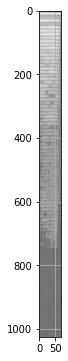

In [52]:
# Plot Spectrogram of audio to test
plt.figure(figsize=(10,6))
plt.imshow(20*specgram.log10().numpy(), cmap='gray')
plt.grid()

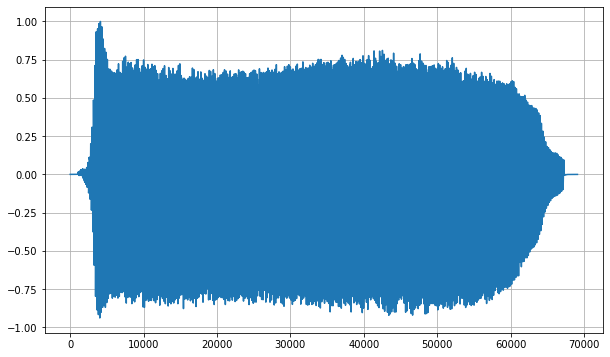

In [53]:
# Plot Waveform of audio to test
plt.figure(figsize=(10,6))
plt.plot(audio_to_test[0,0,:])
plt.grid()

In [54]:
# Listen to audio
ipd.Audio(audio_to_test[0,0,:], rate=44100) # load a local WAV file

# **Experiment Results for experiment 2**

#  load pickle file needed for plotting results for experiment 2

In [119]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/histexp2.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [120]:
hist = hist1['hist']
print(hist)

{'valid_loss': [0.6558845449564732], 'valid_loss_decoder': [0.00012231606008827382], 'valid_loss_total': [0.6681161510003595], 'valid_accuracies': [0.7790284128043848], 'valid_predictions': [[18, 8, 6, 3, 19, 2, 4, 19, 4, 12, 17, 2, 9, 15, 6, 17, 8, 18, 5, 6, 14, 3, 19, 15, 12, 19, 17, 12, 19, 14, 9, 6, 2, 9, 19, 14, 14, 1, 15, 2, 4, 4, 5, 18, 15, 10, 12, 8, 17, 18, 19, 8, 15, 8, 19, 19, 2, 10, 3, 12, 4, 16, 9, 1, 8, 6, 12, 16, 4, 12, 7, 3, 15, 1, 17, 1, 9, 14, 1, 12, 5, 15, 8, 9, 2, 13, 17, 8, 6, 12, 6, 4, 1, 14, 7, 12, 18, 19, 17, 19, 17, 2, 8, 6, 9, 12, 19, 2, 3, 8, 16, 1, 5, 6, 1, 1, 18, 15, 15, 8, 17, 13, 2, 8, 19, 15, 3, 9, 1, 7, 1, 15, 8, 12, 8, 7, 6, 9, 19, 17, 19, 17, 15, 6, 5, 18, 4, 6, 19, 9, 15, 17, 4, 8, 5, 9, 19, 7, 4, 6, 8, 5, 4, 7, 7, 17, 14, 17, 5, 16, 15, 17, 17, 1, 4, 1, 1, 8, 9, 5, 6, 19, 1, 14, 12, 2, 3, 19, 11, 6, 16, 14, 18, 10, 1, 17, 14, 19, 16, 3, 12, 19, 19, 8, 4, 0, 2, 1, 4, 15, 14, 7, 3, 4, 15, 16, 5, 19, 9, 8, 19, 13, 19, 6, 17, 6, 14, 12, 1, 12, 1, 14, 17

In [121]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))
print(torch.tensor(hist["valid_predictions"]))
print(torch.tensor(np.argmax(onehot_labels_test,axis=1)))

Validation errors 755 (out of 3421)
Validation correct 2666 (out of 3421)
tensor([[18,  8,  6,  ...,  4, 12, 19]])
tensor([18,  3,  6,  ...,  3, 12, 19])


In [122]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

bc_correct_pred = []
bc_wrong_pred = []
#print(hist['valid_predictions'][0][(correct_pred[0][0])])

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])
  bc_wrong_pred.append(hist['valid_predictions'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])
  bc_correct_pred.append(hist['valid_predictions'][0][(correct_pred[0][y])])
for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])




#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

(array([   0,    2,    5, ..., 3417, 3419, 3420]),)


In [123]:
test_list = test_set['duration'].values.tolist()
test_class = test_set['class'].values.tolist()
print(len(test_class))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

3421


In [124]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [125]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))


Bar Chart for Correct Predictions for experiment2

In [133]:
banjo = bc_correct_pred.count(0)
bassclarinet = bc_correct_pred.count(1)
bassoon = bc_correct_pred.count(2)
cello = bc_correct_pred.count(3)
clarinet = bc_correct_pred.count(4)
contrabassoon = bc_correct_pred.count(5)
doublebass = bc_correct_pred.count(6)
englishhorn = bc_correct_pred.count(7)
flute = bc_correct_pred.count(8)
frenchhorn = bc_correct_pred.count(9)
guitar = bc_correct_pred.count(10)
mandolin = bc_correct_pred.count(11)
oboe = bc_correct_pred.count(12)
percussion = bc_correct_pred.count(13)
saxophone = bc_correct_pred.count(14)
trombone = bc_correct_pred.count(15)
trumpet = bc_correct_pred.count(16)
tuba = bc_correct_pred.count(17)
viola = bc_correct_pred.count(18)
violin = bc_correct_pred.count(19)

arr = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr)

[15, 215, 141, 130, 167, 156, 170, 160, 158, 117, 19, 13, 110, 19, 140, 182, 79, 208, 188, 279]


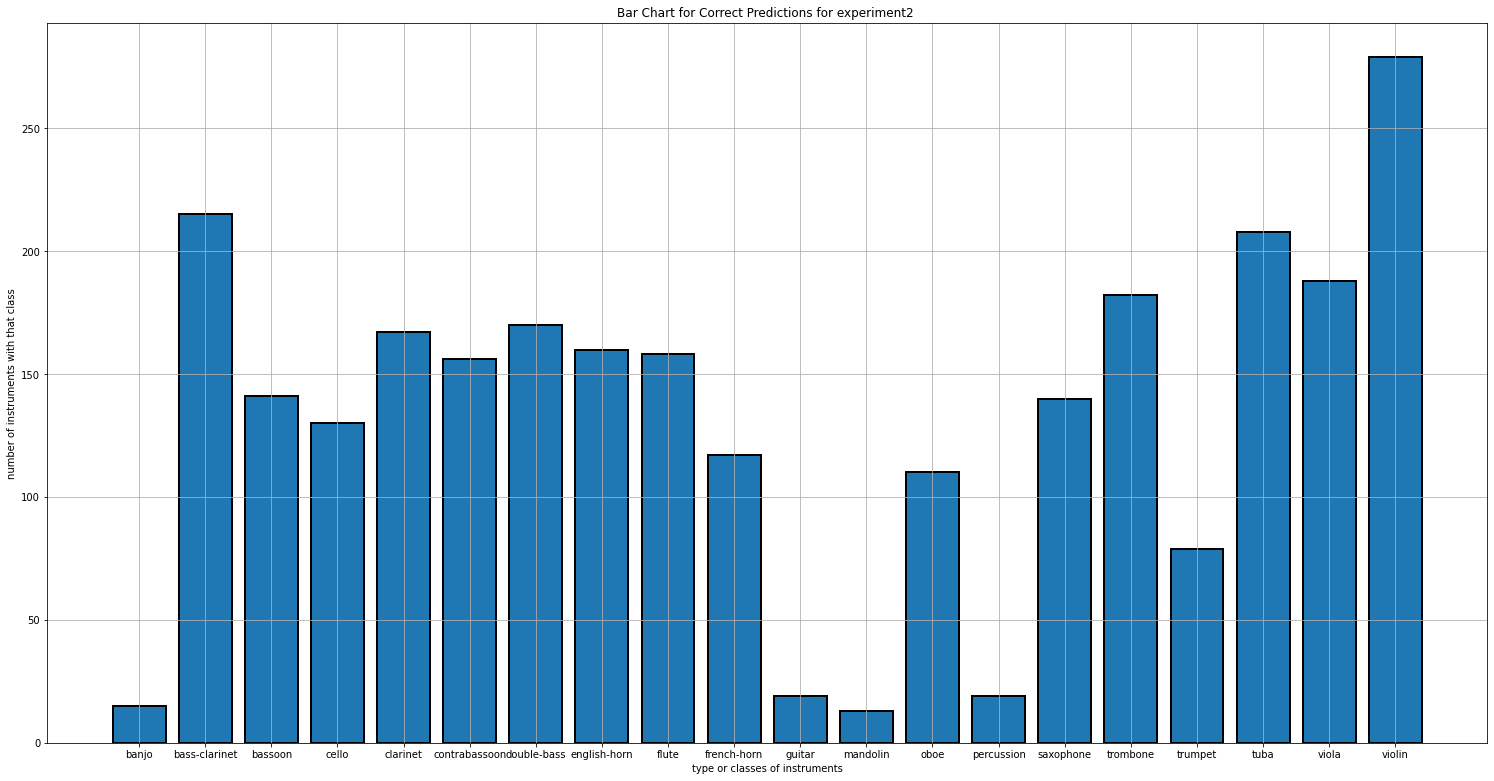

In [134]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Correct Predictions for experiment2 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr,edgecolor="black",linewidth=2)
plt.show()

Bar Chart for Wrong Predictions for experiment2

In [135]:
banjo = bc_wrong_pred.count(0)
bassclarinet = bc_wrong_pred.count(1)
bassoon = bc_wrong_pred.count(2)
cello = bc_wrong_pred.count(3)
clarinet = bc_wrong_pred.count(4)
contrabassoon = bc_wrong_pred.count(5)
doublebass = bc_wrong_pred.count(6)
englishhorn = bc_wrong_pred.count(7)
flute = bc_wrong_pred.count(8)
frenchhorn = bc_wrong_pred.count(9)
guitar = bc_wrong_pred.count(10)
mandolin = bc_wrong_pred.count(11)
oboe = bc_wrong_pred.count(12)
percussion = bc_wrong_pred.count(13)
saxophone = bc_wrong_pred.count(14)
trombone = bc_wrong_pred.count(15)
trumpet = bc_wrong_pred.count(16)
tuba = bc_wrong_pred.count(17)
viola = bc_wrong_pred.count(18)
violin = bc_wrong_pred.count(19)

arr1 = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr1)

[2, 40, 54, 54, 47, 23, 30, 30, 105, 28, 4, 5, 32, 15, 16, 33, 55, 45, 59, 78]


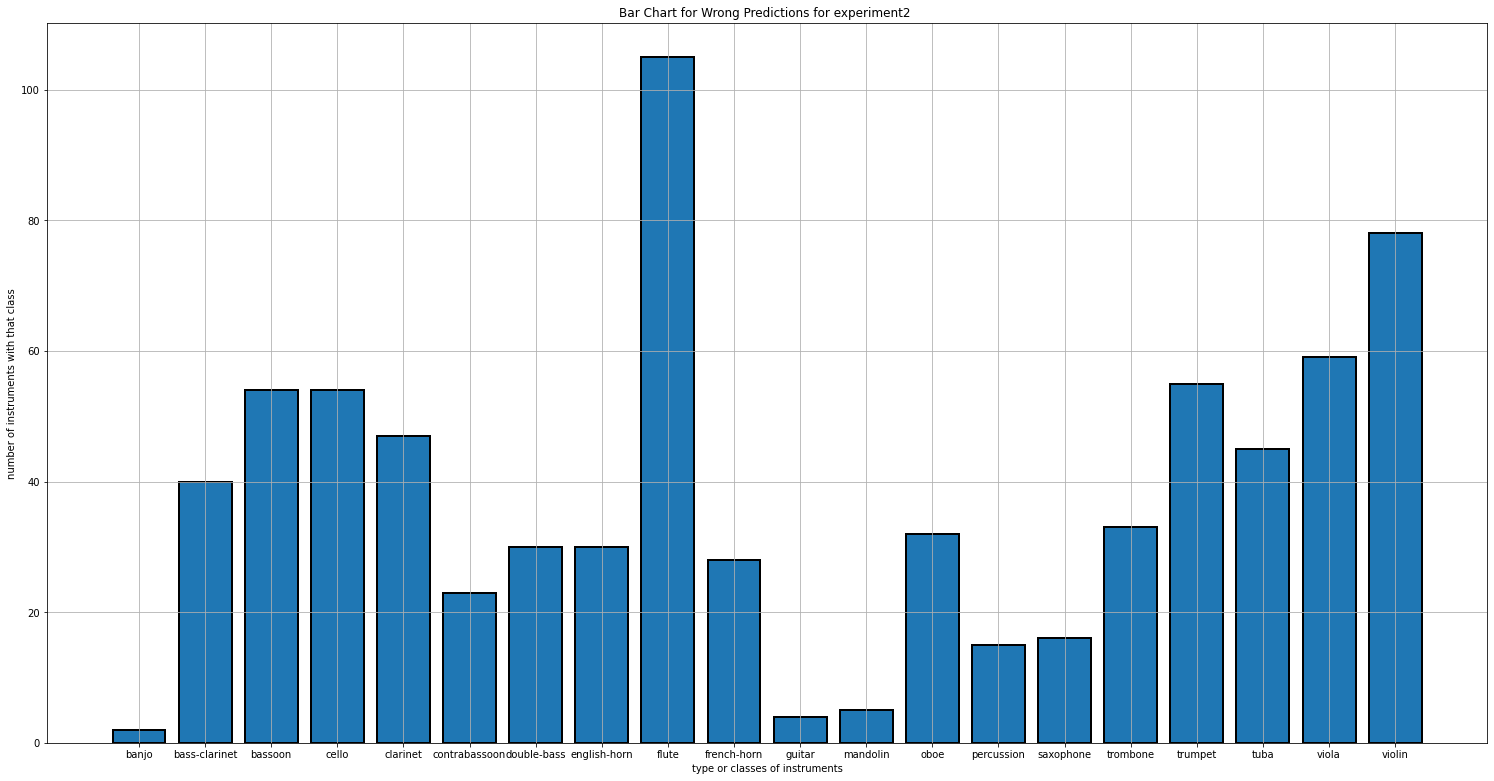

In [136]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Wrong Predictions for experiment2 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr1,edgecolor="black",linewidth=2)
plt.show()

Grouped Bar Chart for Correct and Wrong Predictions for experiment2

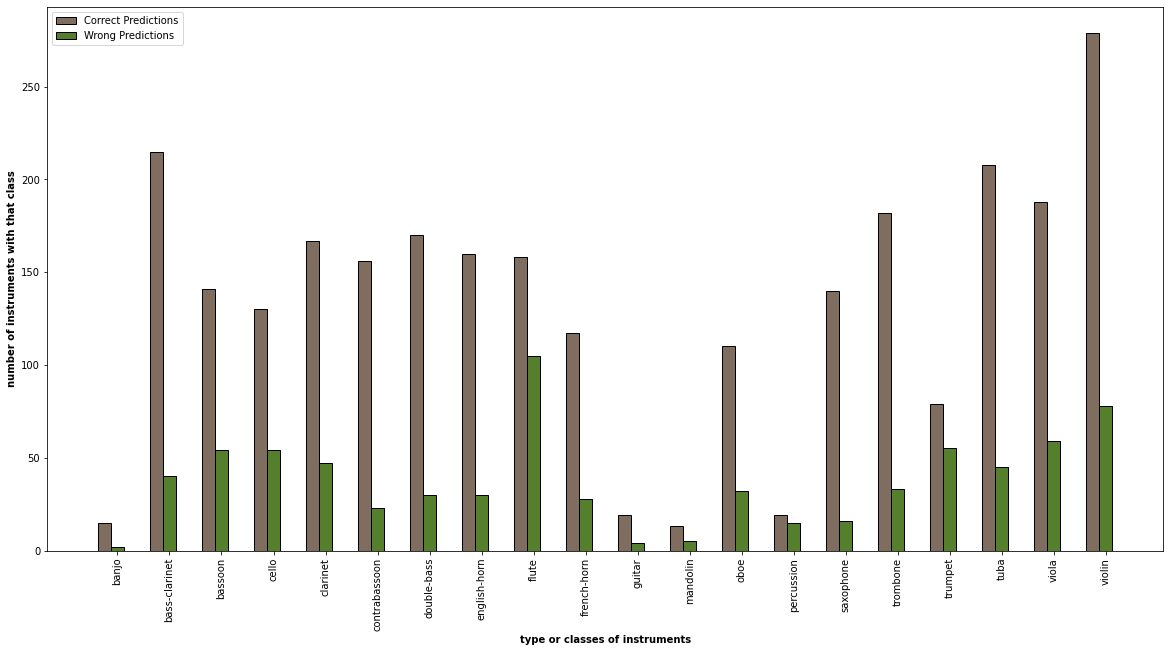

In [168]:
# set width of bars
barWidth = 0.25
plt.figure(figsize=(20, 10))


 
# Set position of bar on X axis
r1 = np.arange(len(arr))
r2 = [x + barWidth for x in r1]

 
# Make the plot
plt.bar(r1, arr, color='#7f6d5f', width=barWidth, edgecolor='black',label='Correct Predictions')
plt.bar(r2, arr1, color='#557f2d', width=barWidth, edgecolor='black', label='Wrong Predictions')


 
# Add xticks on the middle of the group bars
plt.xlabel('type or classes of instruments', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(arr))], classes_instrument,rotation=90)
plt.ylabel('number of instruments with that class',fontweight='bold')
 
# Create legend & Show graphic
plt.legend()
plt.show()

Duration histograms for wrong and correct predictions for experiment2

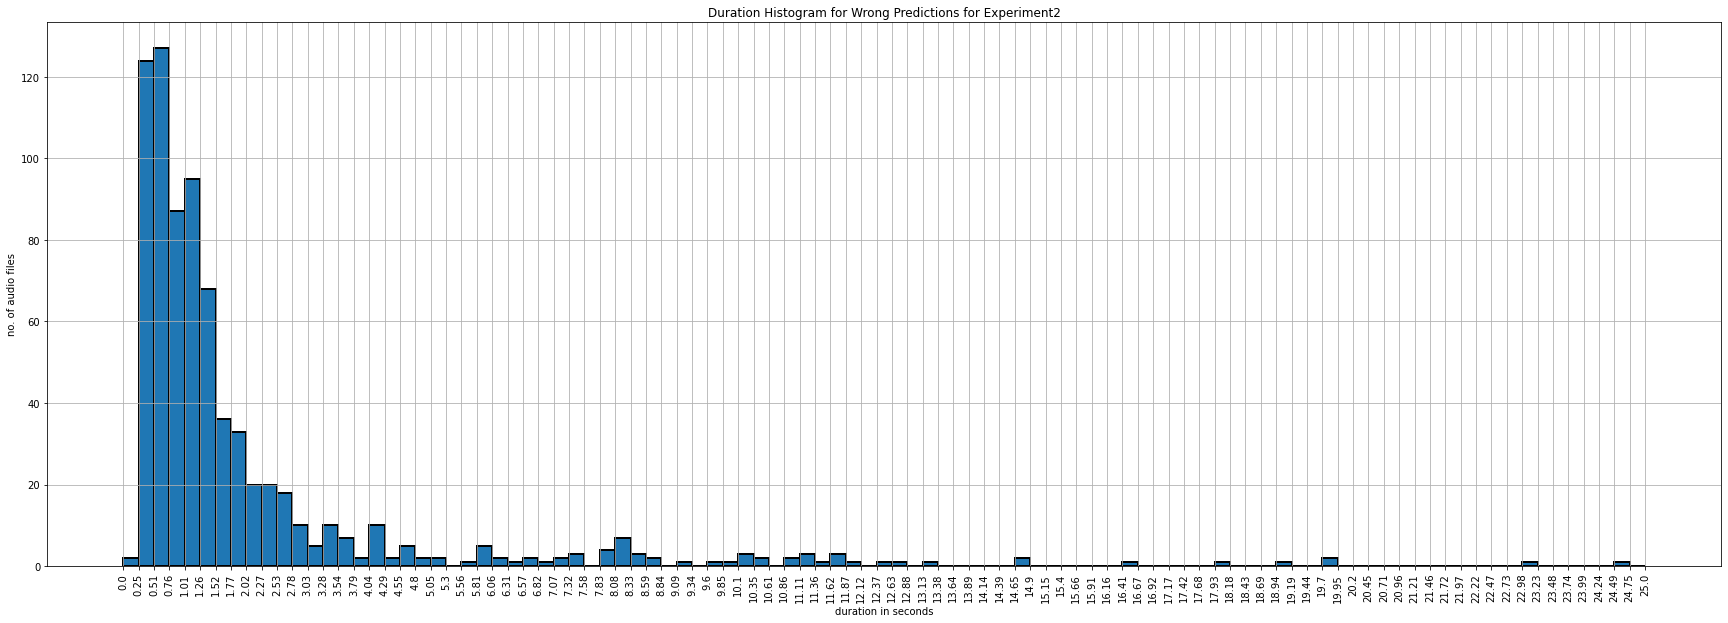

In [153]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Experiment2")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

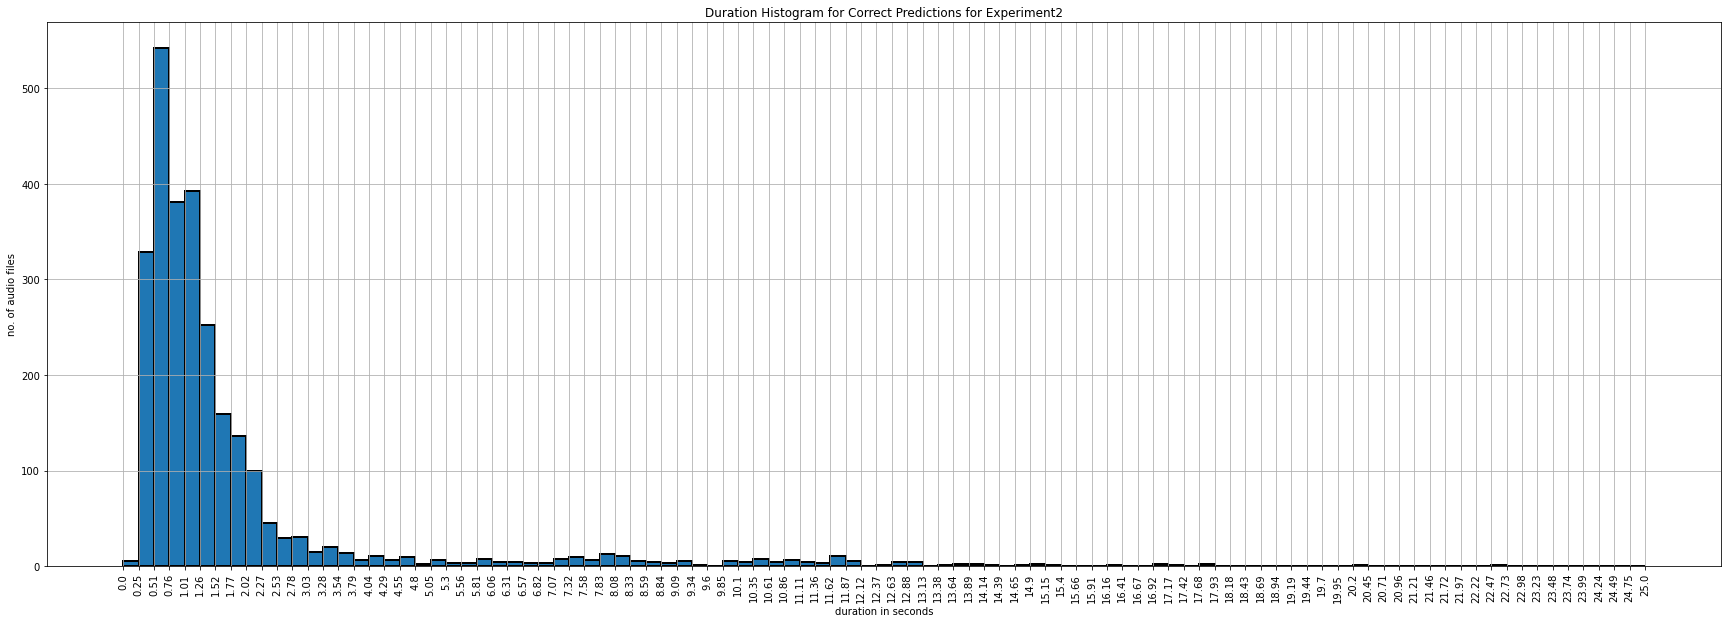

In [154]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Experiment2")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for experiment2

In [155]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

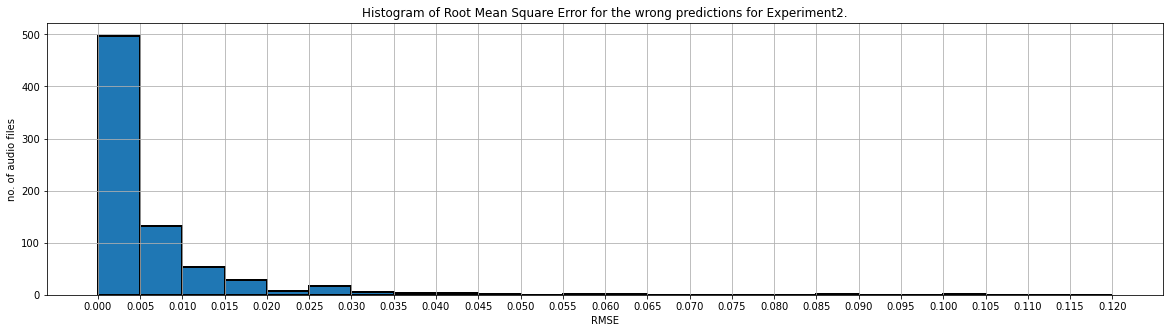

In [156]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

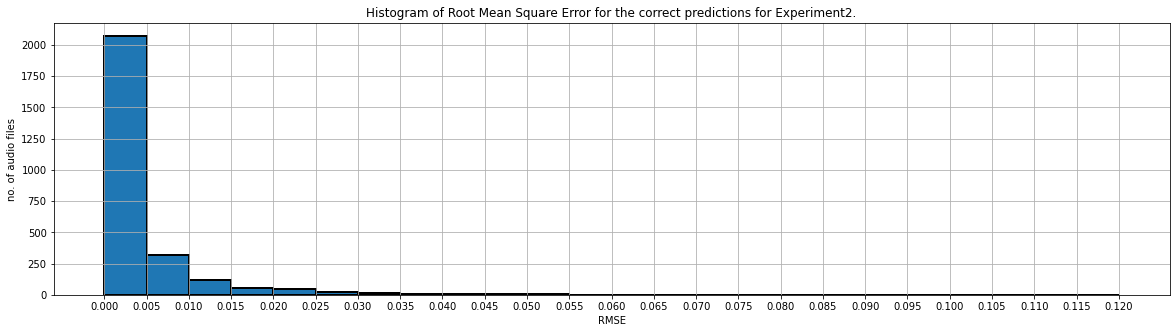

In [157]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

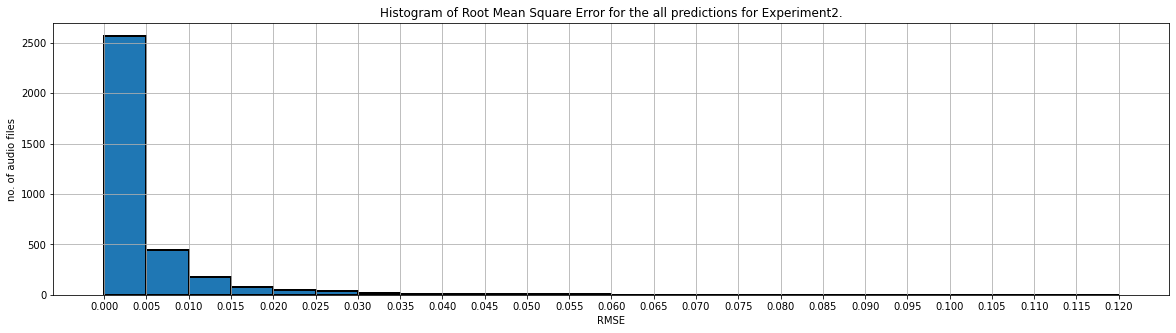

In [158]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [159]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Experiment2

In [160]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.83 0.91 0.78 0.59 0.79 0.88 0.8  0.92 0.72 0.72 0.73 0.65 0.74 0.51
 0.77 0.88 0.65 0.86 0.77 0.74]
Precision:  [0.88 0.84 0.72 0.71 0.78 0.87 0.85 0.84 0.6  0.81 0.83 0.72 0.77 0.56
 0.9  0.85 0.59 0.82 0.76 0.78]
F1-Score:  [0.86 0.88 0.75 0.64 0.78 0.87 0.82 0.88 0.65 0.76 0.78 0.68 0.76 0.54
 0.83 0.86 0.62 0.84 0.77 0.76]
Accuracy: 0.78  , 2666
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       0.84      0.91      0.88       236
           2       0.72      0.78      0.75       180
           3       0.71      0.59      0.64       222
           4       0.78      0.79      0.78       212
           5       0.87      0.88      0.87       178
           6       0.85      0.80      0.82       213
           7       0.84      0.92      0.88       173
           8       0.60      0.72      0.65       220
           9       0.81      0.72      0.76       163
          10     

In [169]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [170]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

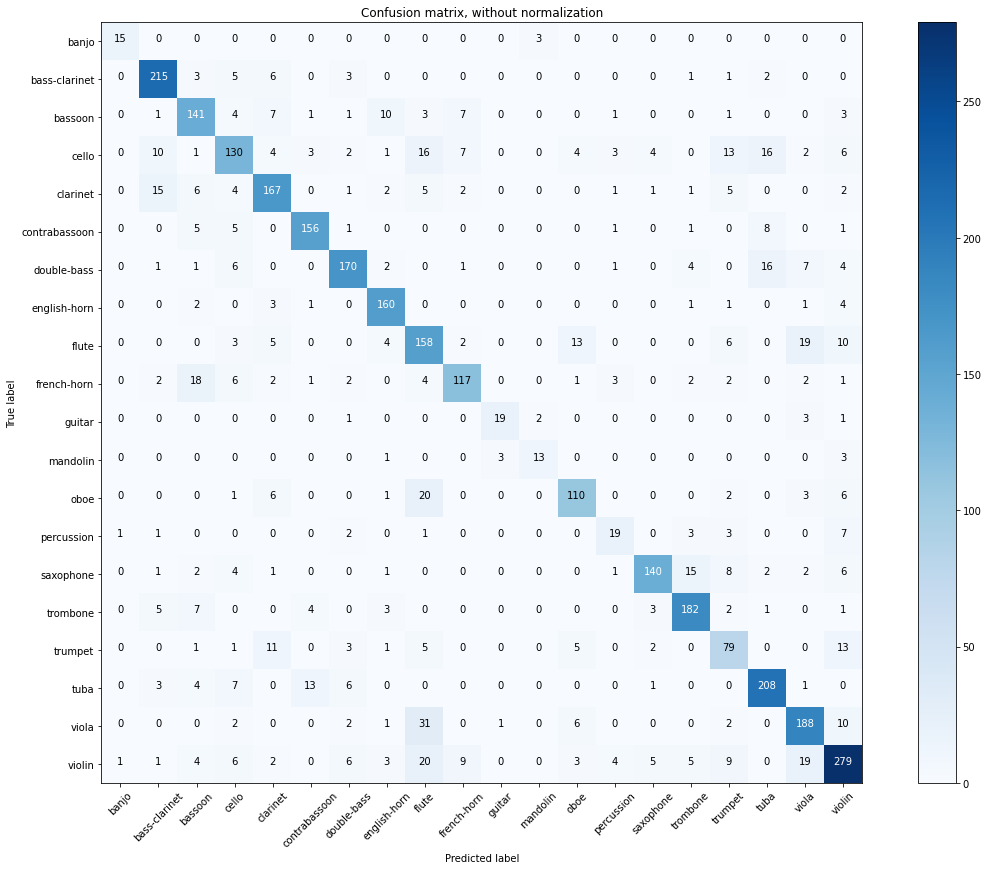

In [171]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Experiment Results for experiment 3**

#  load pickle file needed for plotting results for experiment 3

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment3/histexp3.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
#print(hist)

In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 609 (out of 3421)
Validation correct 2812 (out of 3421)


In [ ]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
#print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])

for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])


#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

In [ ]:
test_list = test_set['duration'].values.tolist()
#print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
#print(len(correct_pred_value))

In [ ]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))


Duration histograms for wrong and correct predictions for experiment3

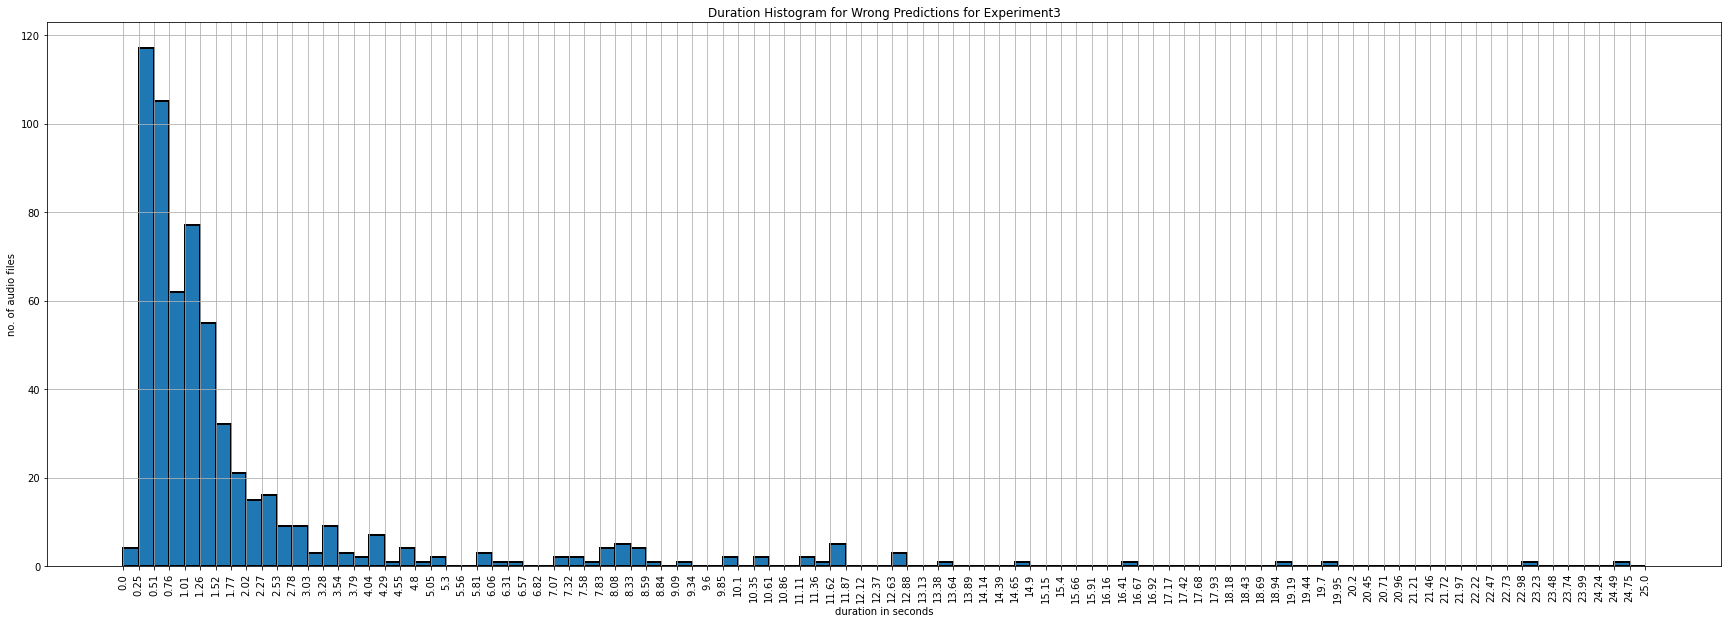

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Experiment3")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

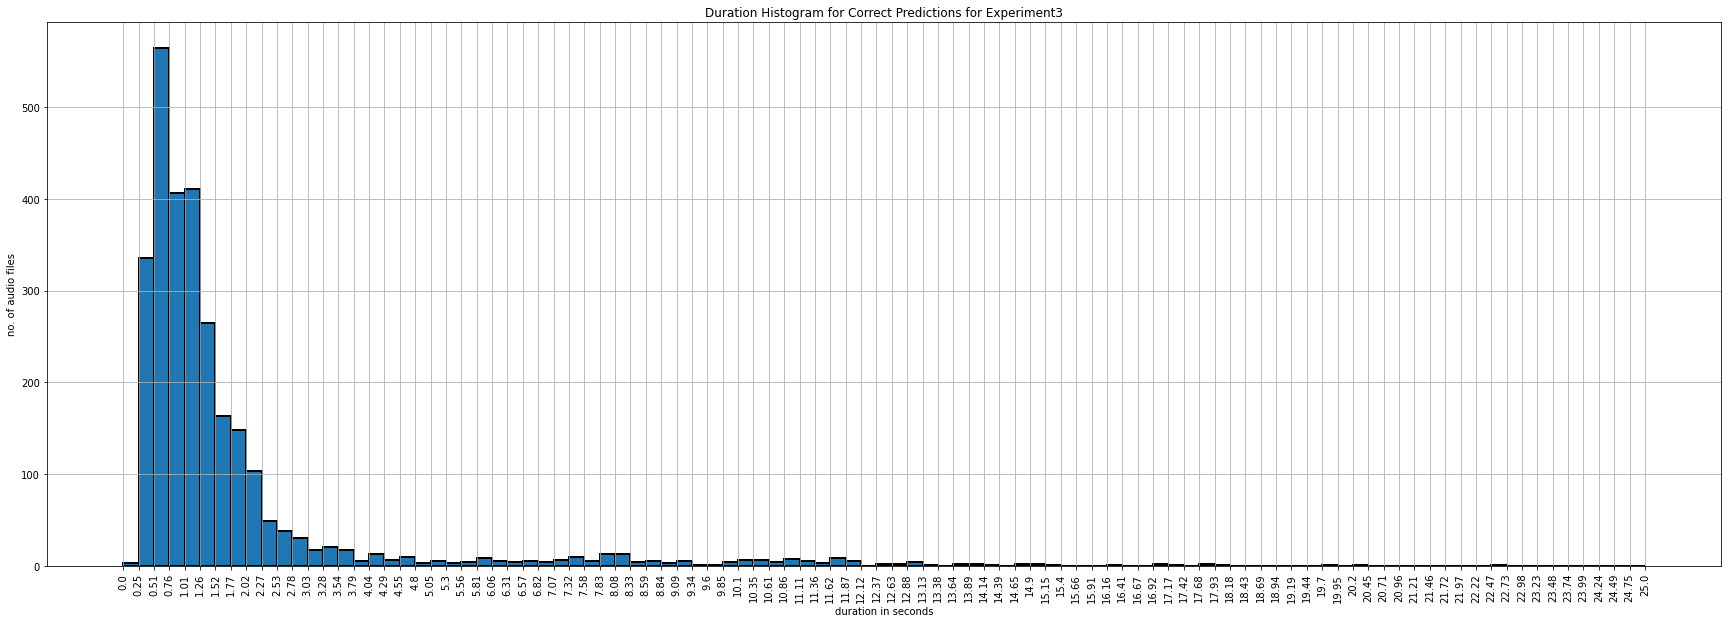

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Experiment3")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for experiment3

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

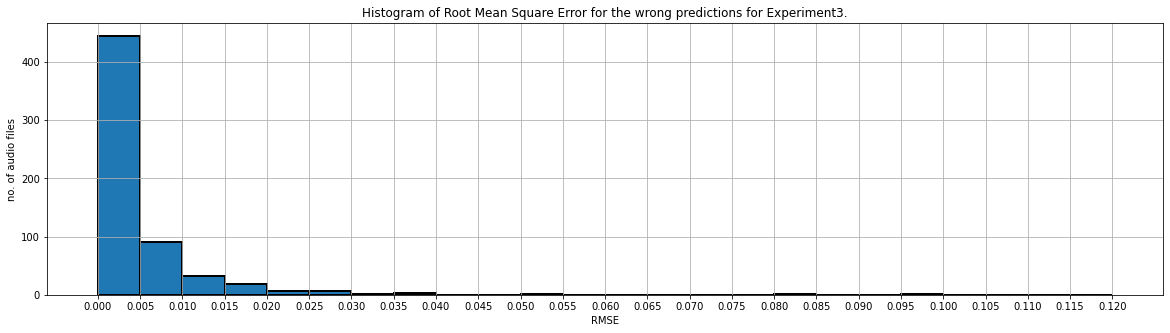

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Experiment3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

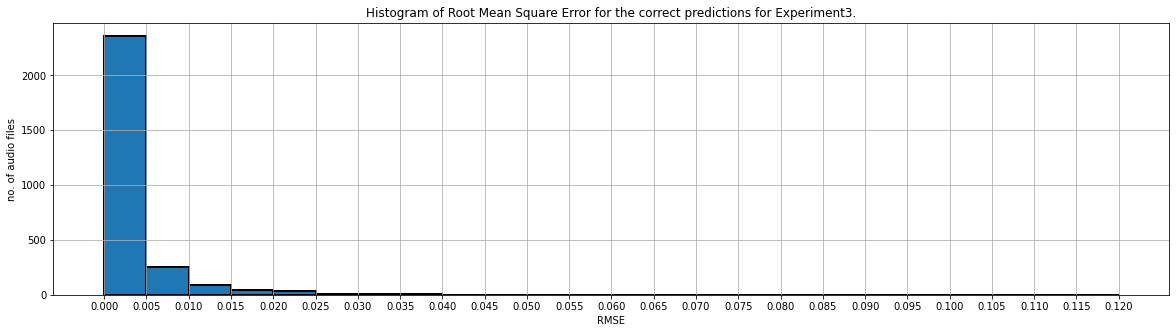

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Experiment3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

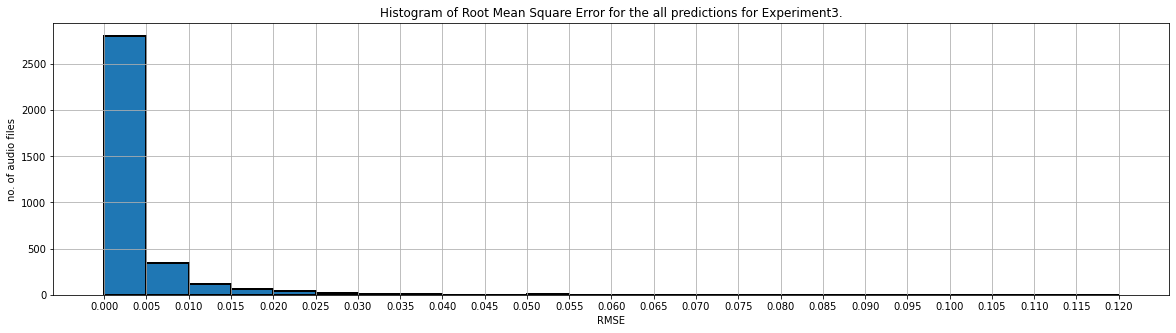

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Experiment3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Experiment3

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.89 0.91 0.85 0.71 0.82 0.9  0.82 0.96 0.73 0.83 0.81 0.55 0.81 0.51
 0.81 0.91 0.64 0.88 0.82 0.8 ]
Precision:  [0.84 0.93 0.85 0.75 0.82 0.87 0.85 0.87 0.64 0.85 0.75 0.79 0.8  0.68
 0.94 0.9  0.68 0.88 0.77 0.81]
F1-Score:  [0.86 0.92 0.85 0.73 0.82 0.88 0.84 0.91 0.68 0.84 0.78 0.65 0.8  0.58
 0.87 0.9  0.66 0.88 0.79 0.8 ]
Accuracy: 0.82  , 2812
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.93      0.91      0.92       236
           2       0.85      0.85      0.85       180
           3       0.75      0.71      0.73       222
           4       0.82      0.82      0.82       212
           5       0.87      0.90      0.88       178
           6       0.85      0.82      0.84       213
           7       0.87      0.96      0.91       173
           8       0.64      0.73      0.68       220
           9       0.85      0.83      0.84       163
          10     

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

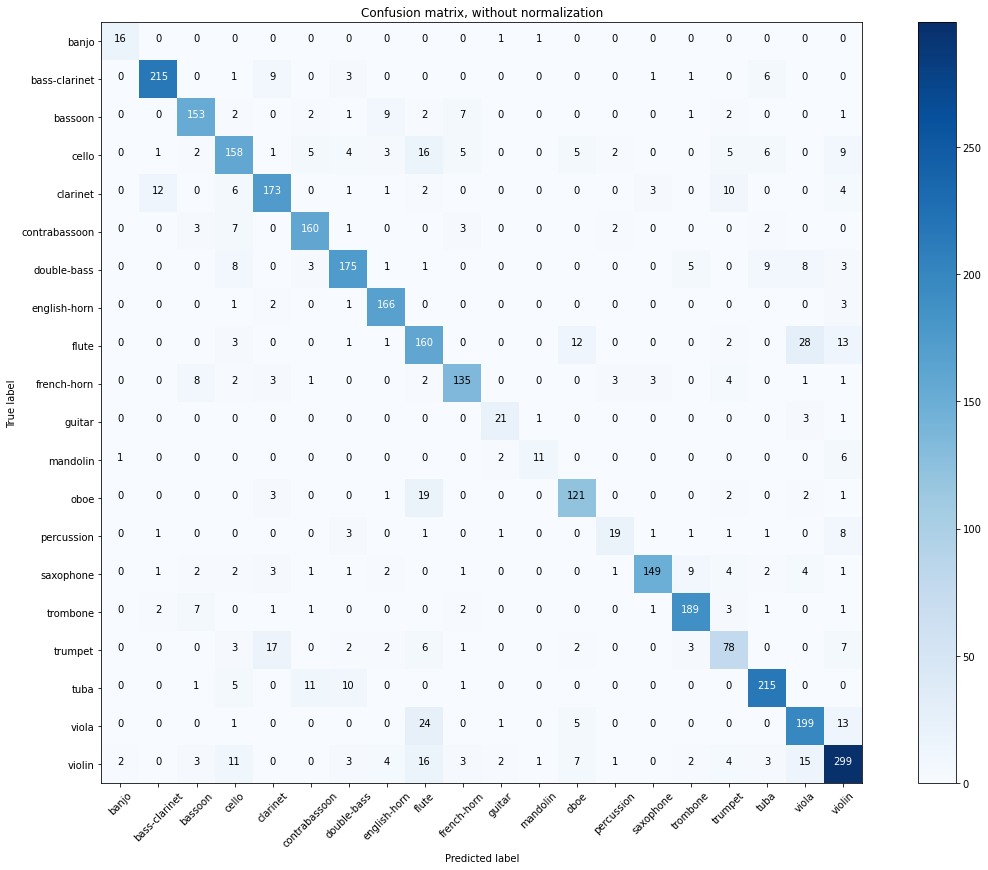

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Experiment Results for experiment 4**

#  load pickle file needed for plotting results for experiment 4

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment4/histexp4.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
#print(hist)

In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 697 (out of 3421)
Validation correct 2724 (out of 3421)


In [ ]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
#print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])

for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])


#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

In [ ]:
test_list = test_set['duration'].values.tolist()
#print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
#print(len(correct_pred_value))

In [ ]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))


Duration histograms for wrong and correct predictions for experiment4

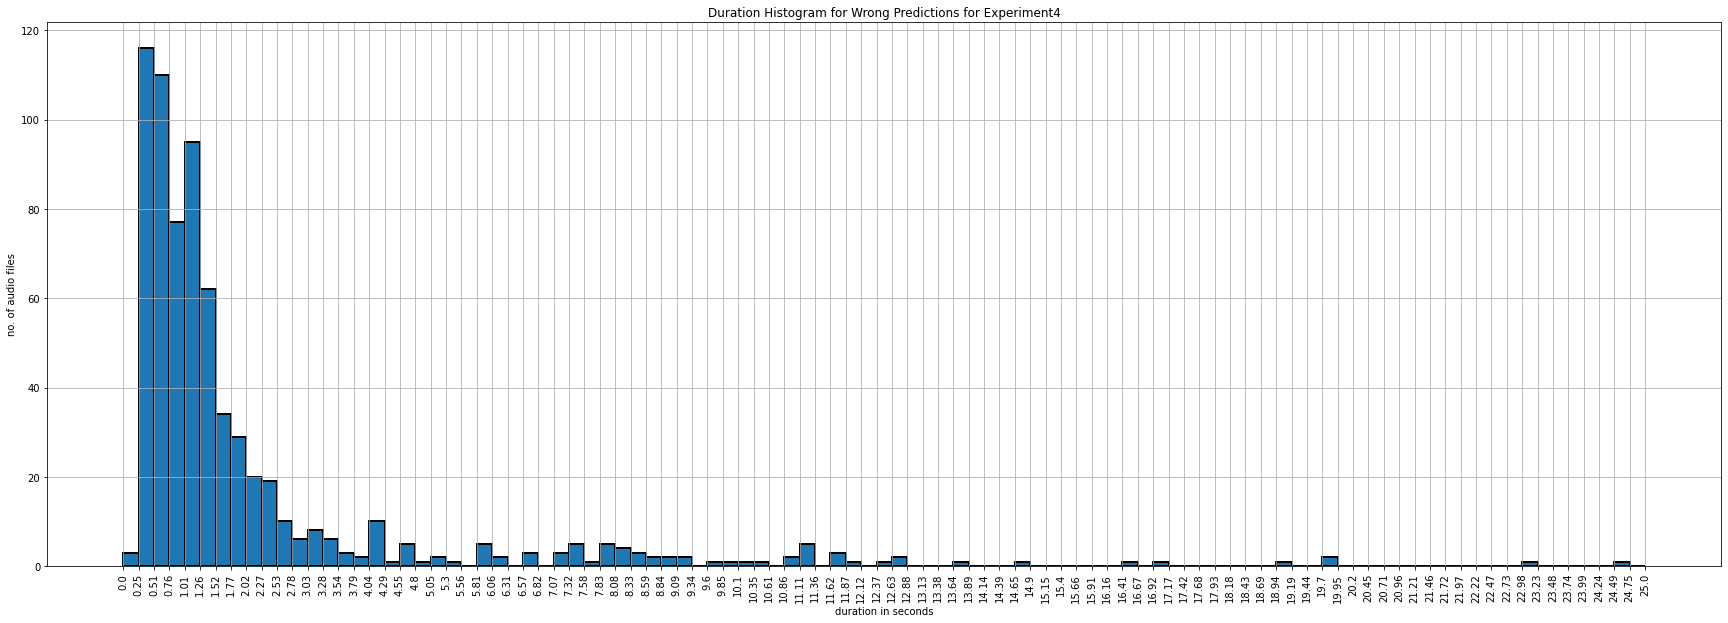

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Experiment4")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

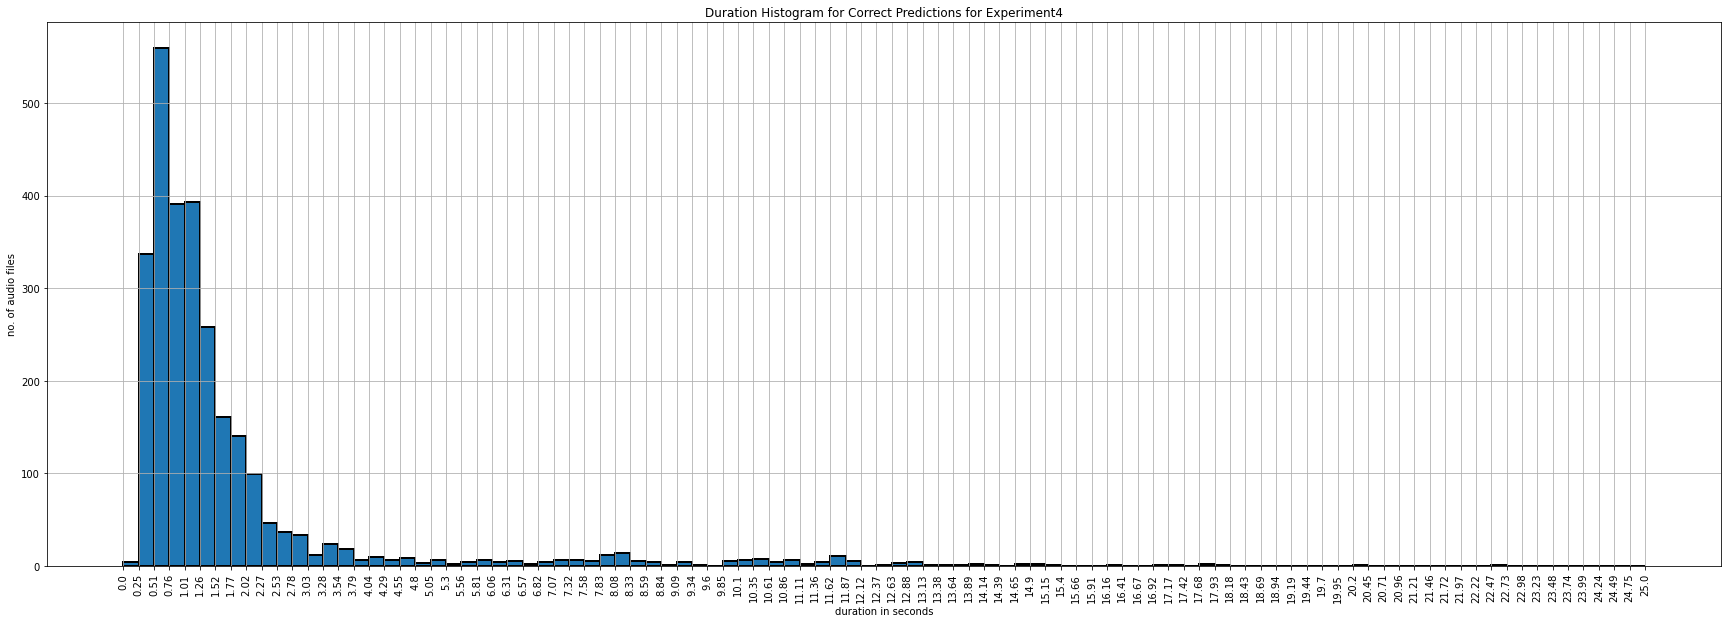

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Experiment4")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for experiment4

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

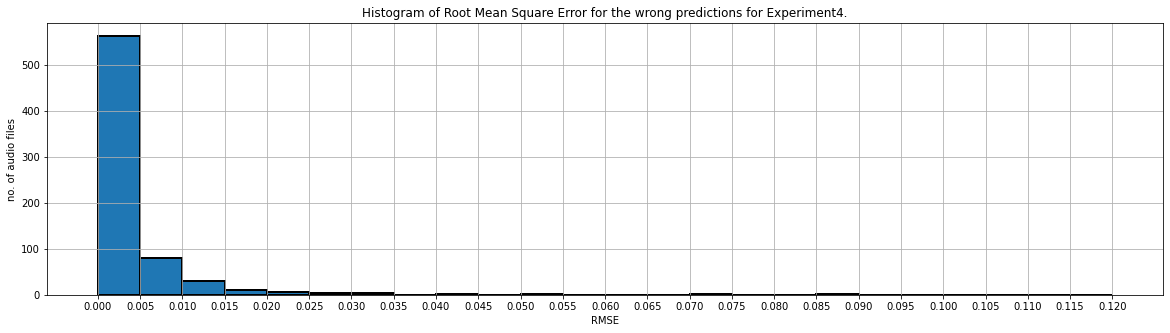

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Experiment4.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

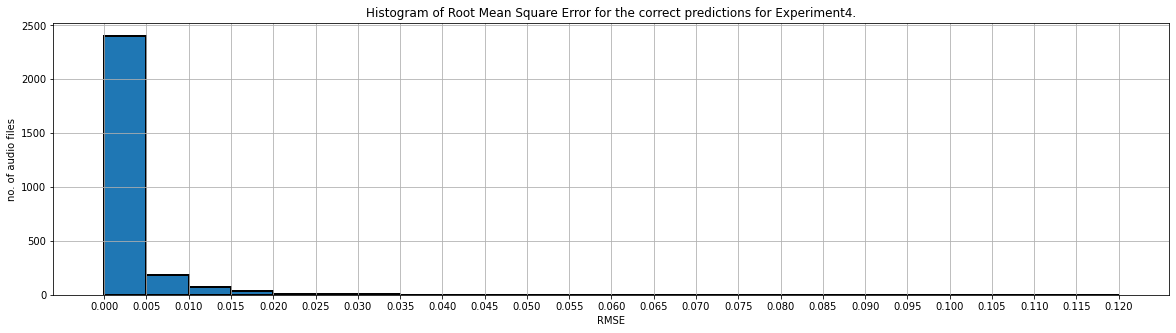

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Experiment4.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

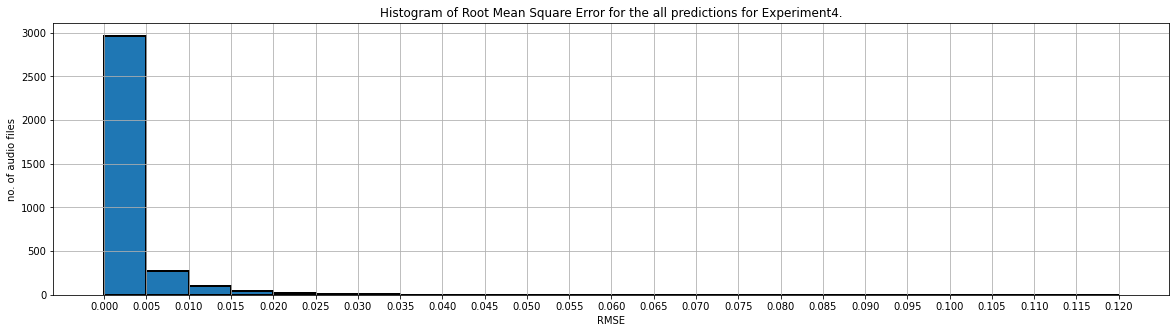

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Experiment4.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Experiment4

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.89 0.92 0.73 0.61 0.84 0.85 0.87 0.91 0.71 0.81 0.85 0.75 0.77 0.43
 0.77 0.82 0.64 0.92 0.79 0.77]
Precision:  [0.84 0.91 0.73 0.68 0.85 0.82 0.85 0.83 0.64 0.84 0.92 0.71 0.74 0.59
 0.83 0.88 0.78 0.9  0.72 0.77]
F1-Score:  [0.86 0.92 0.73 0.64 0.85 0.84 0.86 0.87 0.67 0.83 0.88 0.73 0.75 0.5
 0.8  0.85 0.7  0.91 0.76 0.77]
Accuracy: 0.80  , 2724
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.91      0.92      0.92       236
           2       0.73      0.73      0.73       180
           3       0.68      0.61      0.64       222
           4       0.85      0.84      0.85       212
           5       0.82      0.85      0.84       178
           6       0.85      0.87      0.86       213
           7       0.83      0.91      0.87       173
           8       0.64      0.71      0.67       220
           9       0.84      0.81      0.83       163
          10      

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

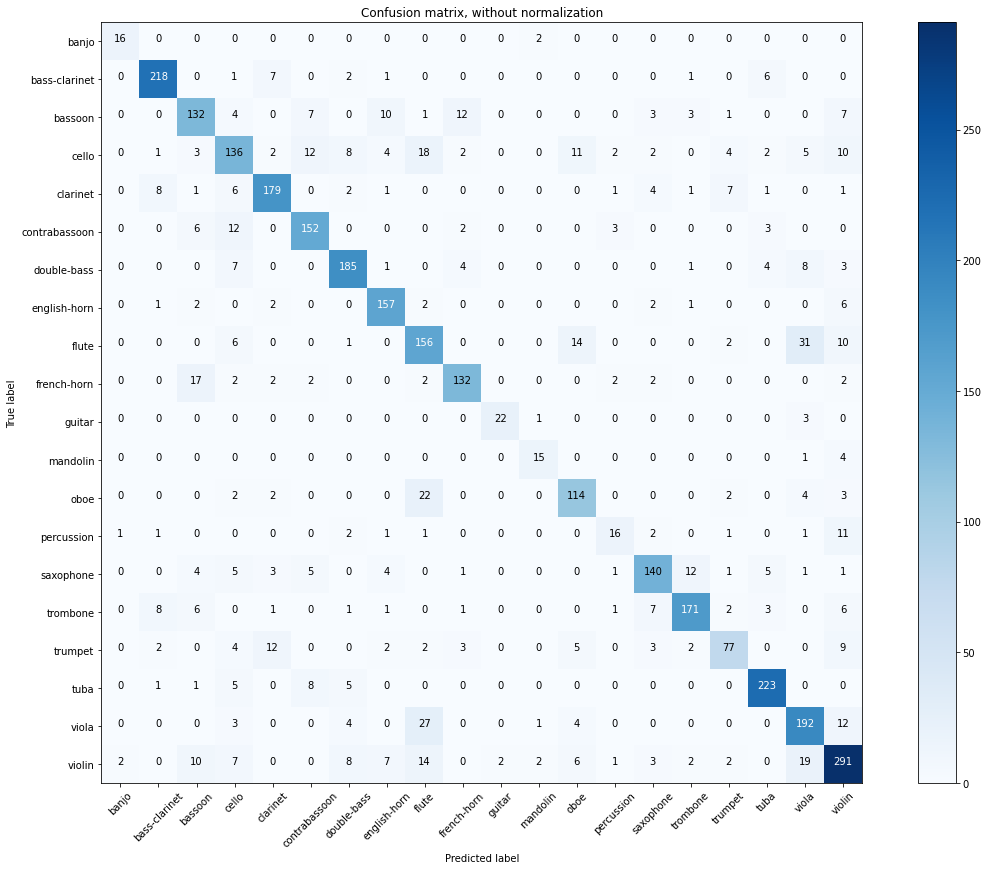

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Experiment Results for experiment 5**

#  load pickle file needed for plotting results for experiment 5

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment5/histexp5.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
#print(hist)

In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 807 (out of 3421)
Validation correct 2614 (out of 3421)


In [ ]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
#print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])

for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])


#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

In [ ]:
test_list = test_set['duration'].values.tolist()
#print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
#print(len(correct_pred_value))

In [ ]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))


Duration histograms for wrong and correct predictions for experiment5

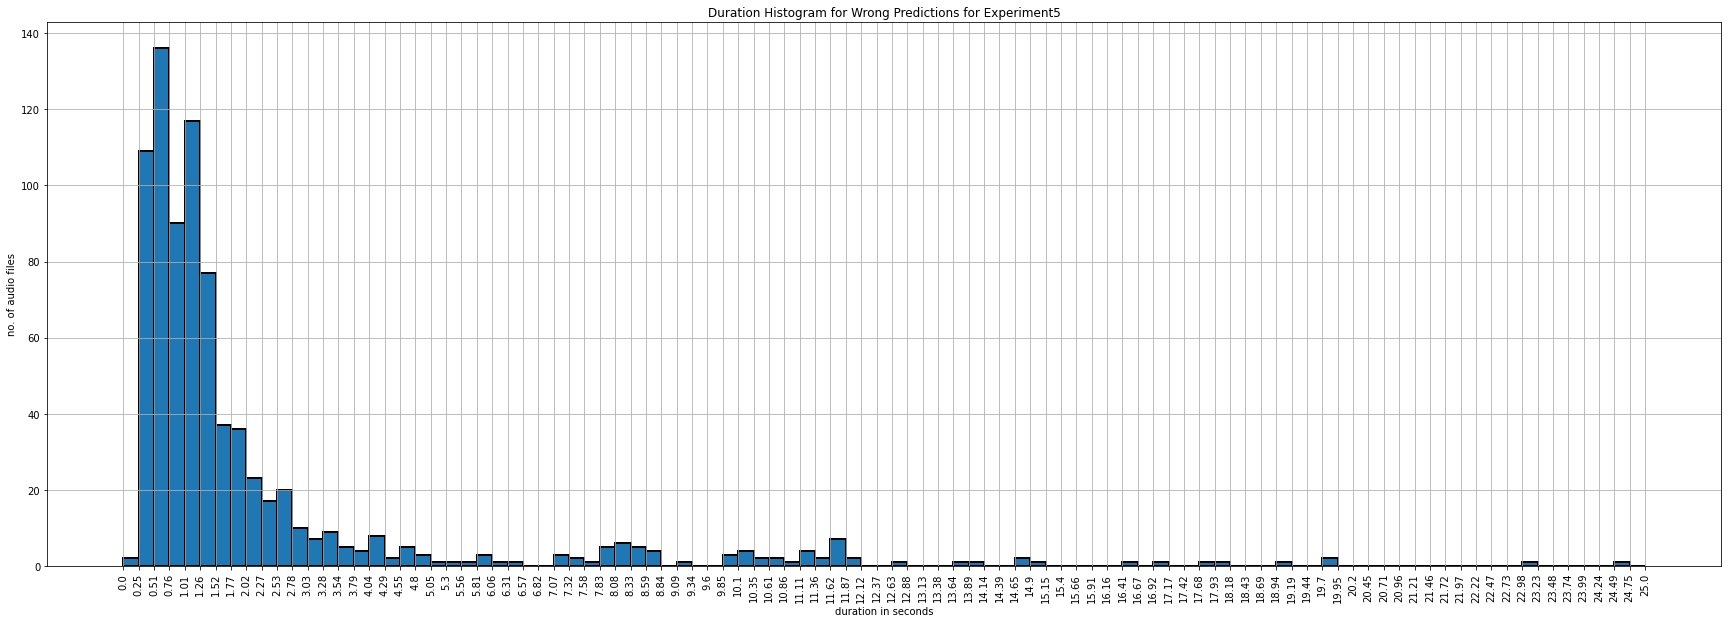

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Experiment5")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

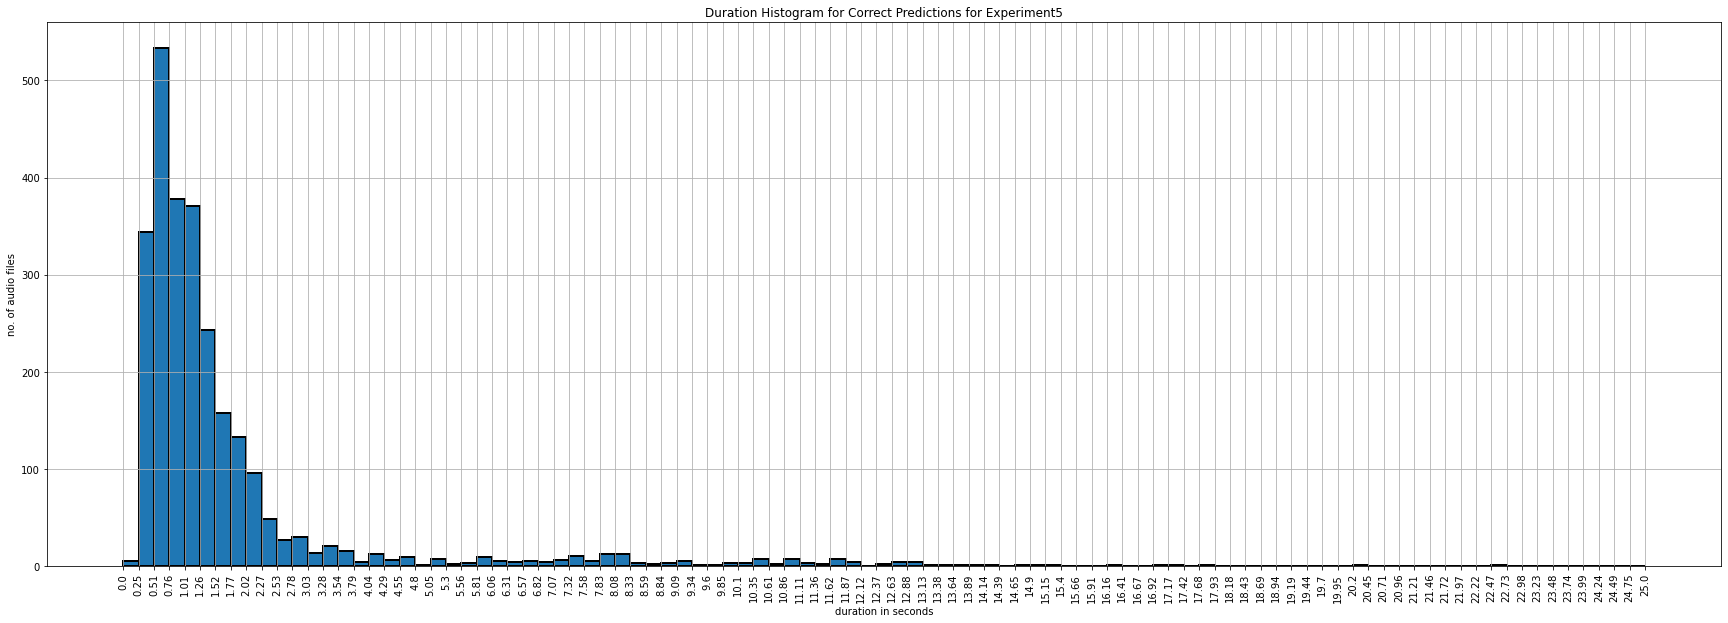

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Experiment5")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for experiment5

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

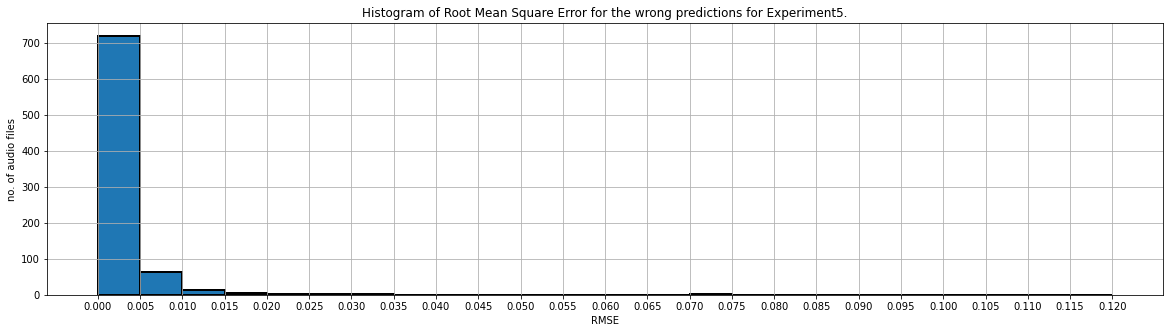

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Experiment5.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

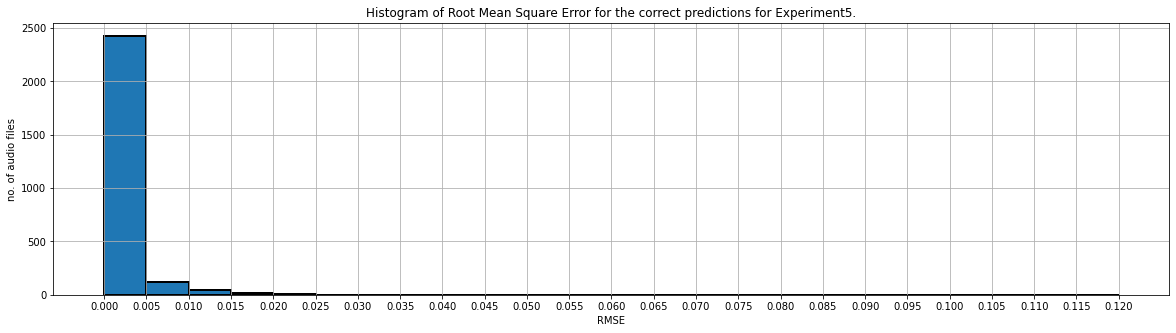

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Experiment5.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

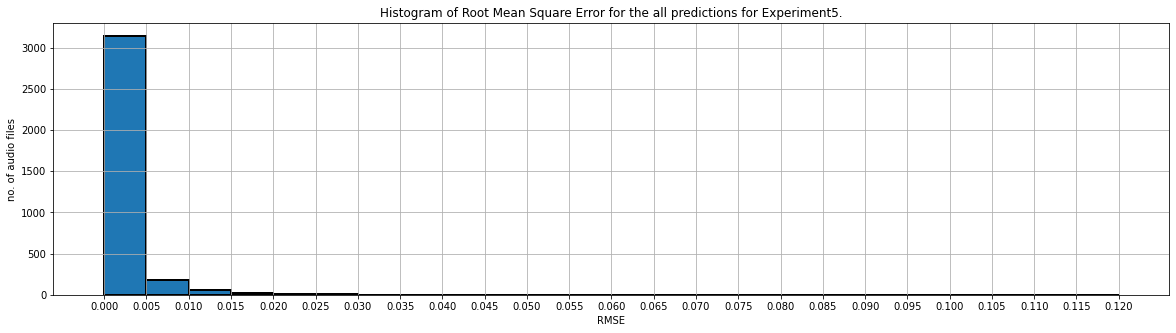

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Experiment5.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Experiment5

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.83 0.89 0.83 0.56 0.84 0.76 0.79 0.91 0.63 0.77 0.85 0.7  0.84 0.54
 0.62 0.86 0.53 0.87 0.71 0.77]
Precision:  [0.94 0.93 0.67 0.61 0.79 0.76 0.8  0.89 0.63 0.78 0.92 0.7  0.75 0.74
 0.77 0.83 0.75 0.86 0.69 0.73]
F1-Score:  [0.88 0.91 0.74 0.58 0.81 0.76 0.8  0.9  0.63 0.77 0.88 0.7  0.79 0.62
 0.69 0.84 0.62 0.87 0.7  0.75]
Accuracy: 0.76  , 2614
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.93      0.89      0.91       236
           2       0.67      0.83      0.74       180
           3       0.61      0.56      0.58       222
           4       0.79      0.84      0.81       212
           5       0.76      0.76      0.76       178
           6       0.80      0.79      0.80       213
           7       0.89      0.91      0.90       173
           8       0.63      0.63      0.63       220
           9       0.78      0.77      0.77       163
          10     

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

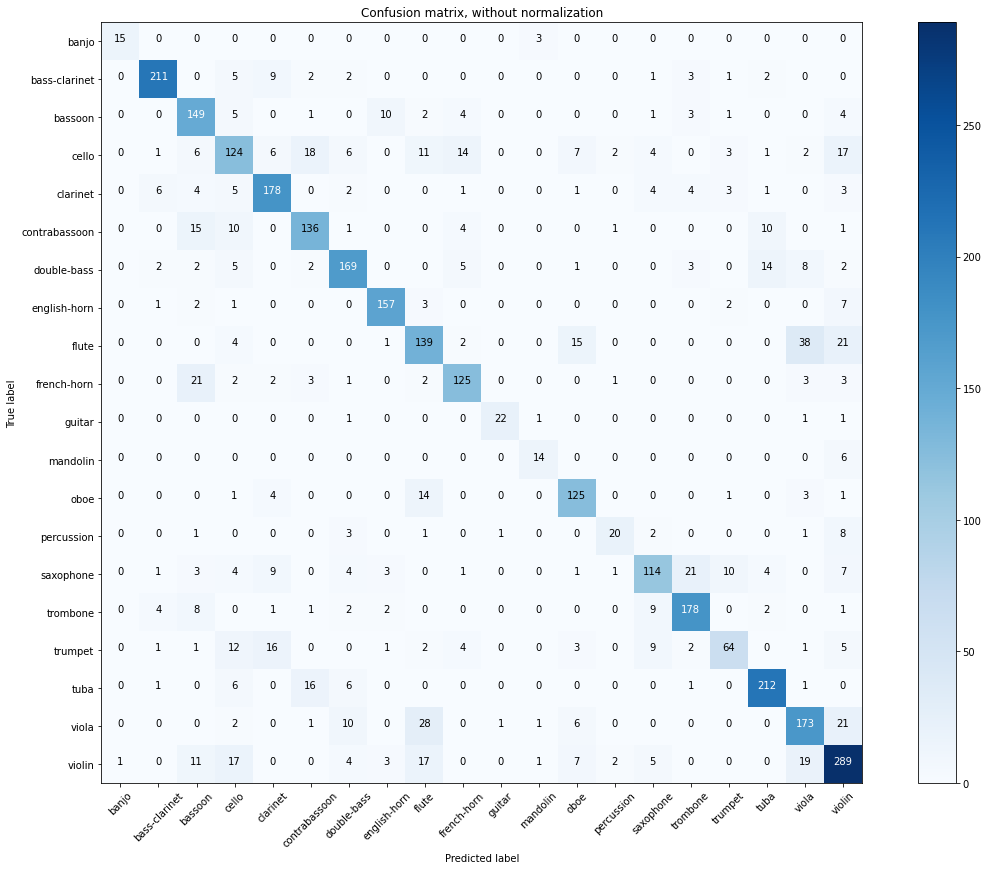

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Experiment Results for Variational Autoencoder experiment 2**

#  load pickle file needed for plotting results for Variational Autoencoder experiment 2

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/VarAutoEncoderExperiment2/histVarAutoEncexp2.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
#print(hist)

In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 835 (out of 3421)
Validation correct 2586 (out of 3421)


In [ ]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
#print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])

for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])


#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

In [ ]:
test_list = test_set['duration'].values.tolist()
#print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
#print(len(correct_pred_value))

In [ ]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))


Duration histograms for wrong and correct predictions for Variational Autoencoder experiment 2

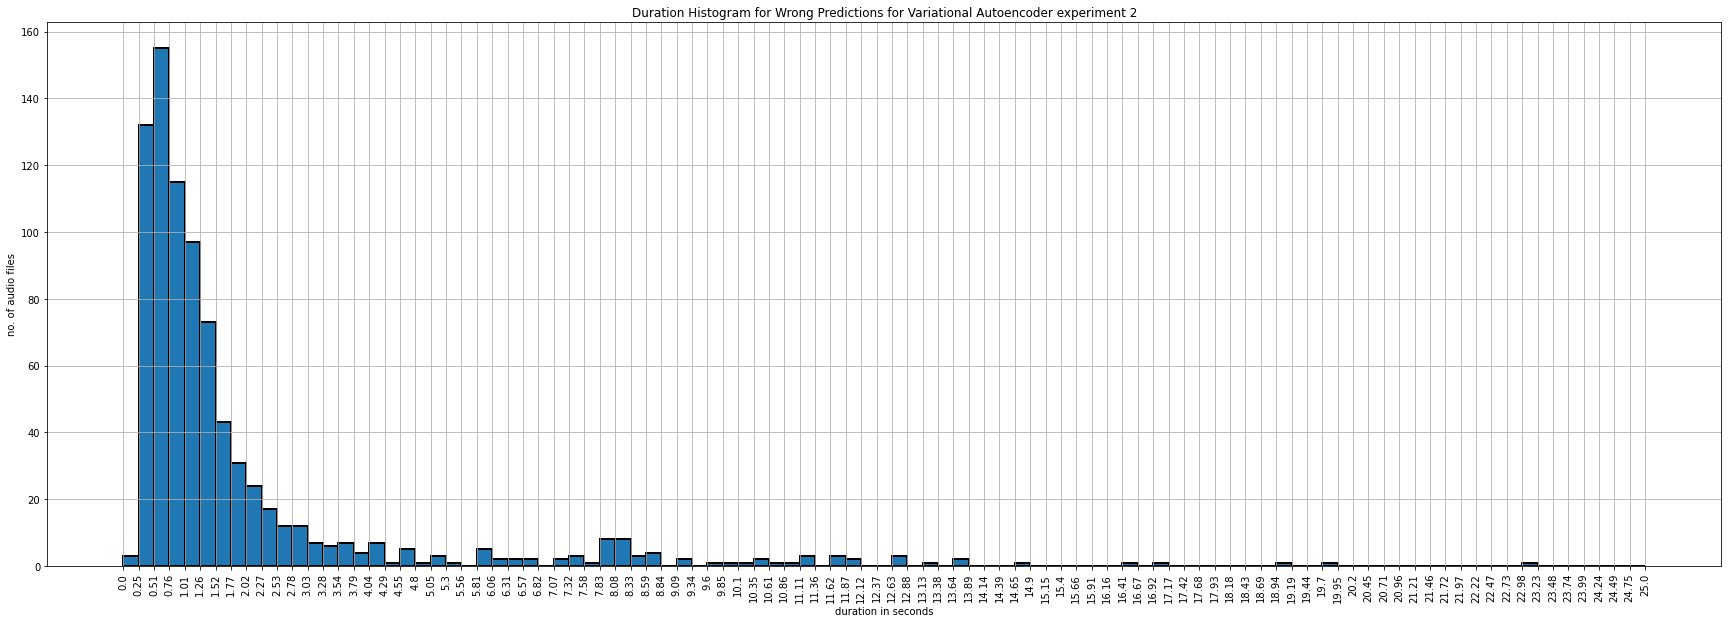

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Variational Autoencoder experiment 2")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

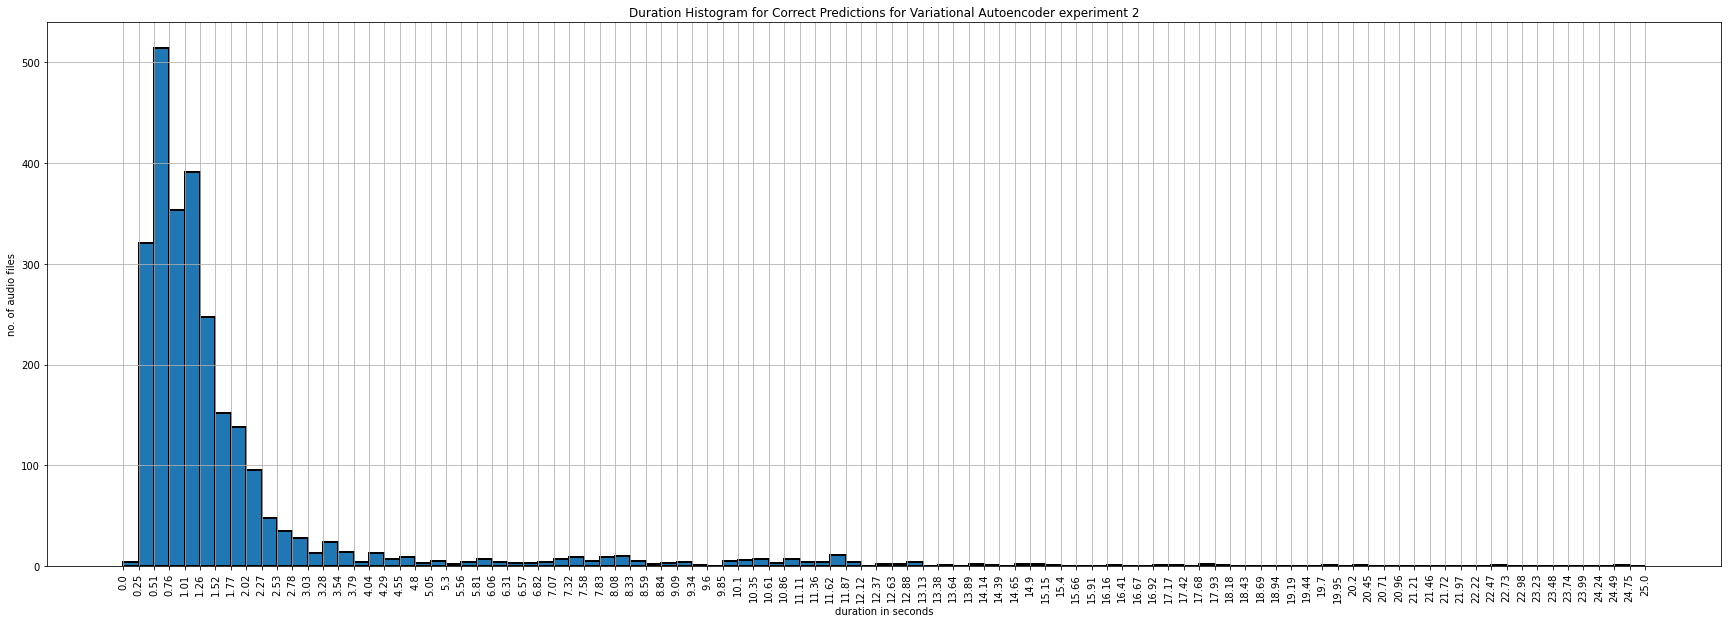

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Variational Autoencoder experiment 2")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for Variational Autoencoder experiment 2

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

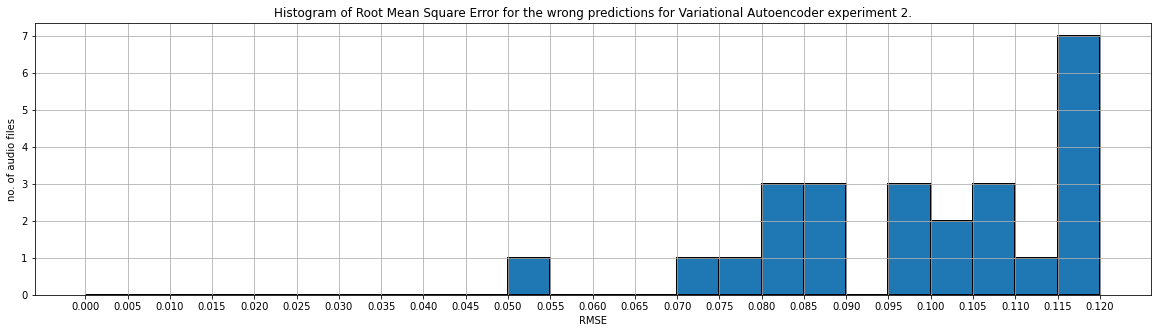

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Variational Autoencoder experiment 2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

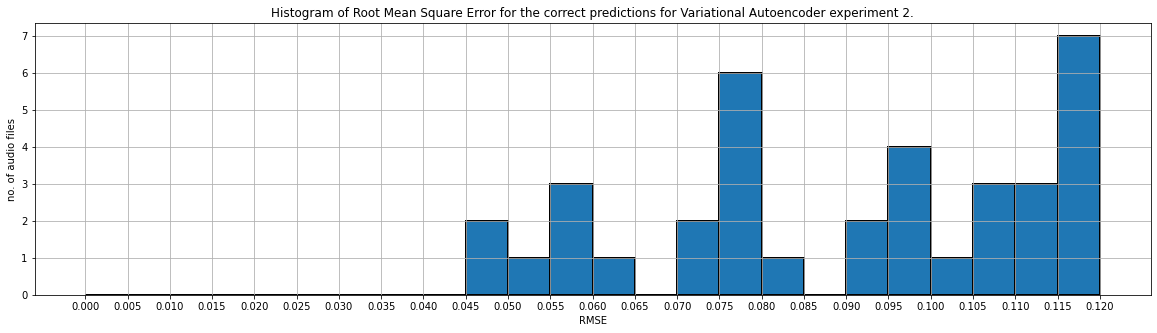

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Variational Autoencoder experiment 2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

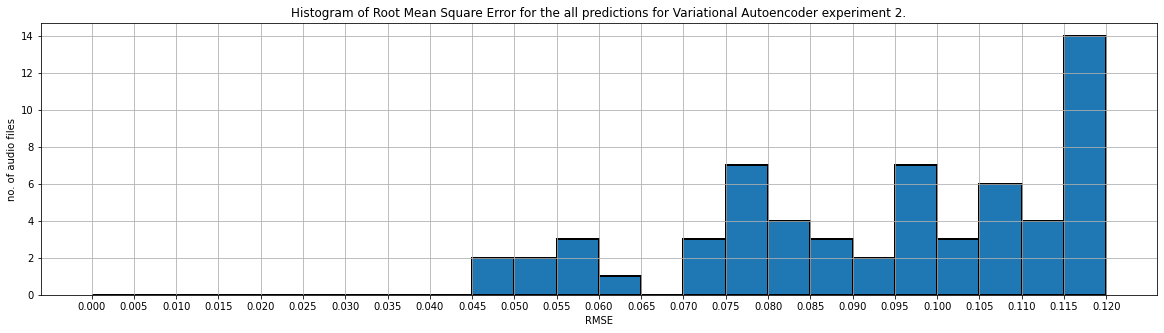

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Variational Autoencoder experiment 2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Variational Autoencoder experiment 2

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.83 0.89 0.83 0.59 0.81 0.79 0.76 0.95 0.7  0.71 0.77 0.35 0.74 0.51
 0.76 0.78 0.67 0.89 0.77 0.62]
Precision:  [0.75 0.82 0.69 0.69 0.74 0.88 0.82 0.82 0.67 0.73 0.54 0.39 0.76 0.63
 0.87 0.83 0.76 0.77 0.65 0.77]
F1-Score:  [0.79 0.85 0.75 0.63 0.77 0.83 0.79 0.88 0.68 0.72 0.63 0.37 0.75 0.57
 0.81 0.81 0.71 0.83 0.71 0.69]
Accuracy: 0.76  , 2586
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        18
           1       0.82      0.89      0.85       236
           2       0.69      0.83      0.75       180
           3       0.69      0.59      0.63       222
           4       0.74      0.81      0.77       212
           5       0.88      0.79      0.83       178
           6       0.82      0.76      0.79       213
           7       0.82      0.95      0.88       173
           8       0.67      0.70      0.68       220
           9       0.73      0.71      0.72       163
          10     

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

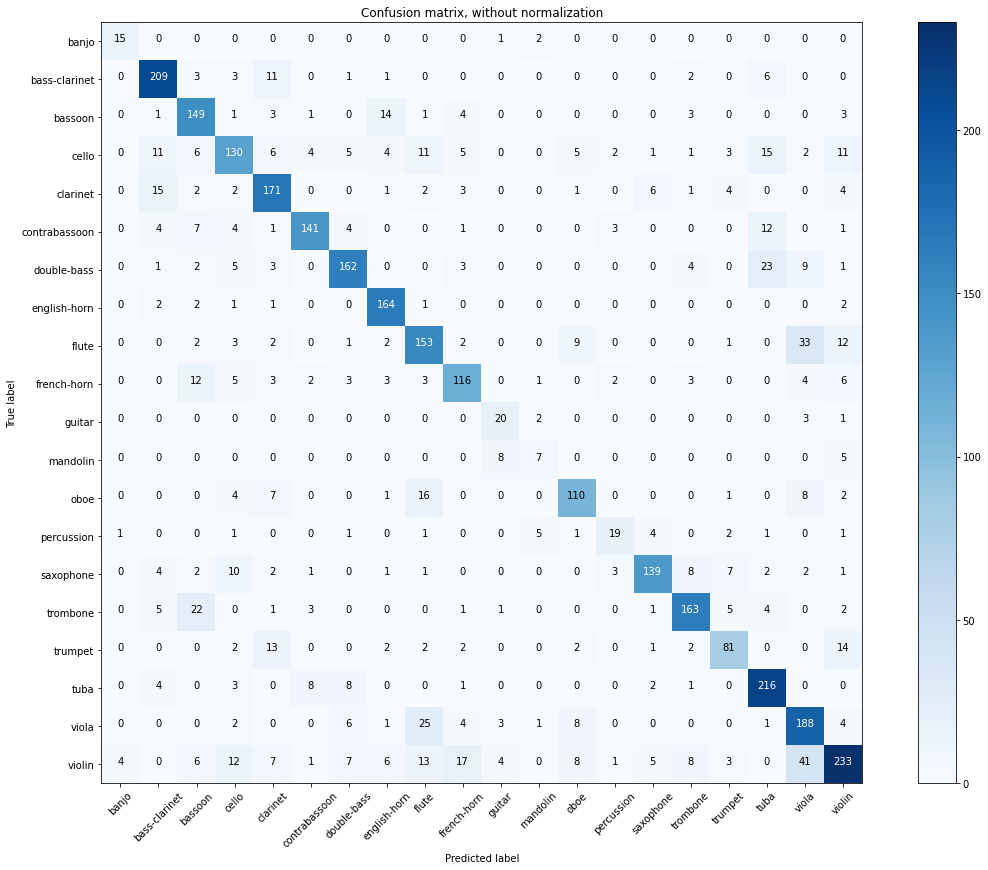

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Experiment Results for Variational Autoencoder experiment 3**

#  load pickle file needed for plotting results for Variational Autoencoder experiment 3

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/VarAutoEncoderExperiment3/histVarAutoEncexp3.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
#print(hist)

In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 718 (out of 3421)
Validation correct 2703 (out of 3421)


In [ ]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
#print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])

for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])


#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

In [ ]:
test_list = test_set['duration'].values.tolist()
#print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
print(len(correct_pred_value))

2703


In [ ]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))


Duration histograms for wrong and correct predictions for Variational Autoencoder experiment 3

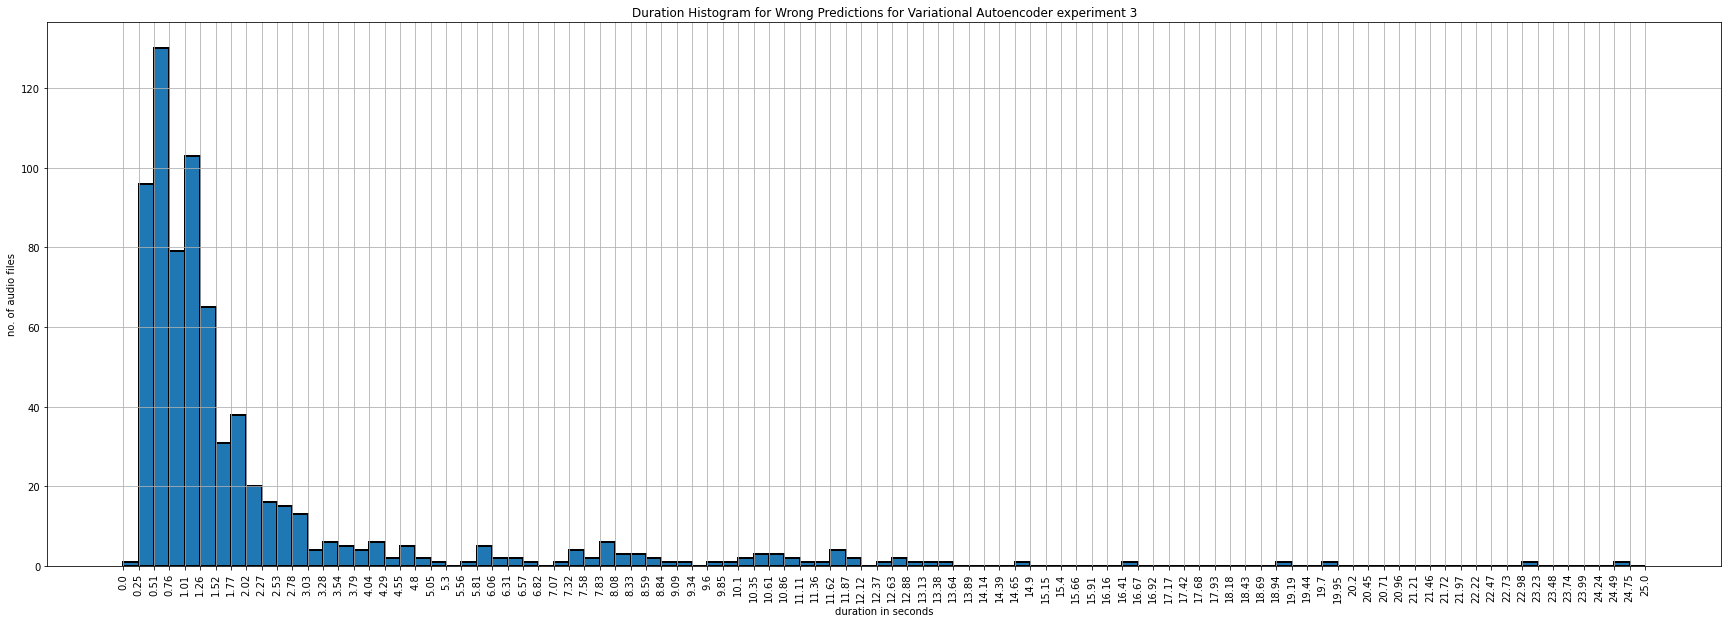

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Variational Autoencoder experiment 3")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

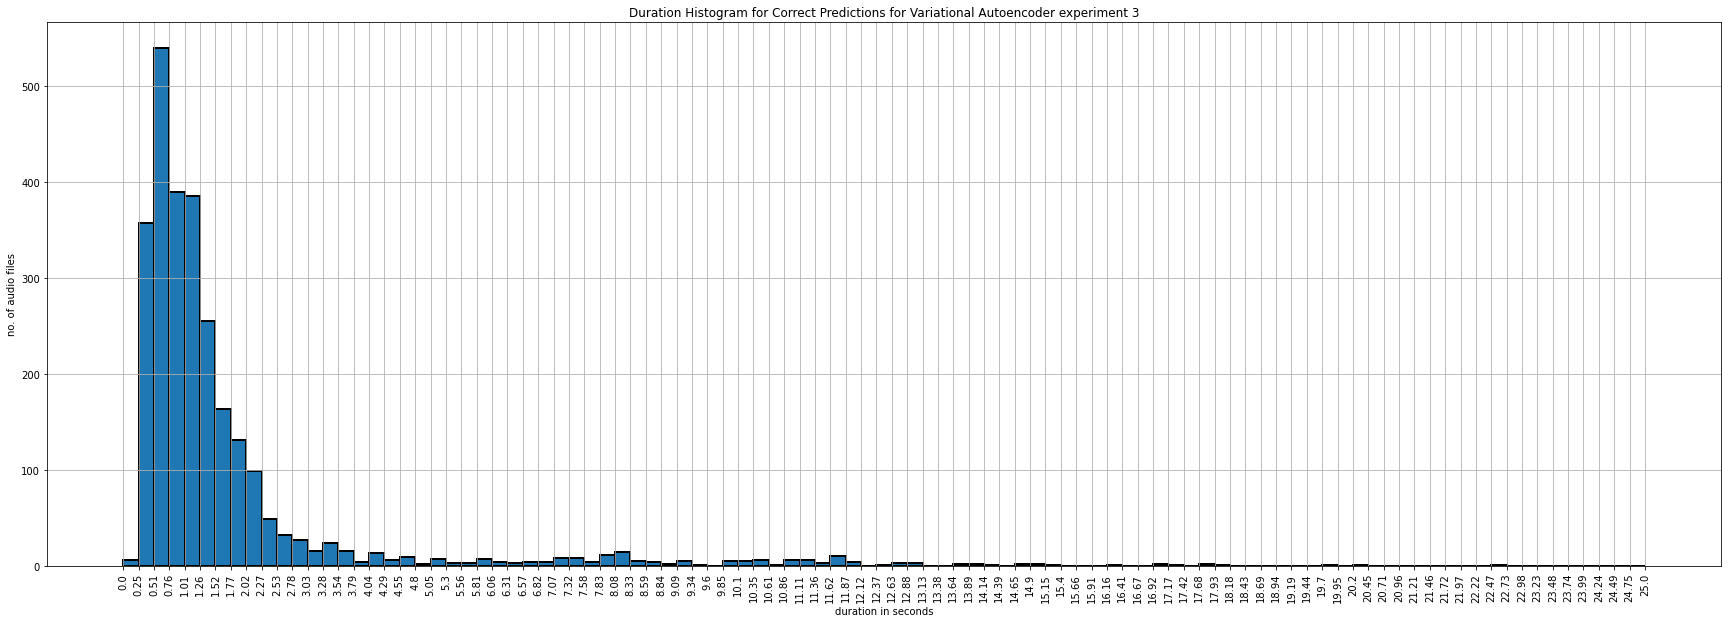

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Variational Autoencoder experiment 3")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for Variational Autoencoder experiment 3

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

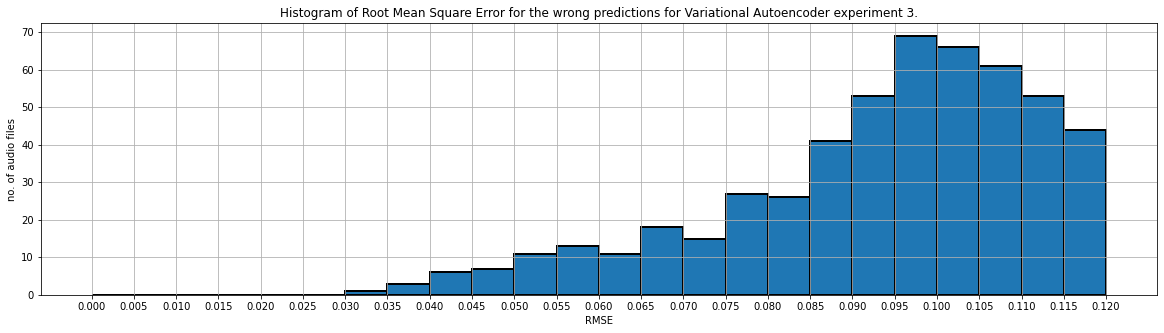

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Variational Autoencoder experiment 3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

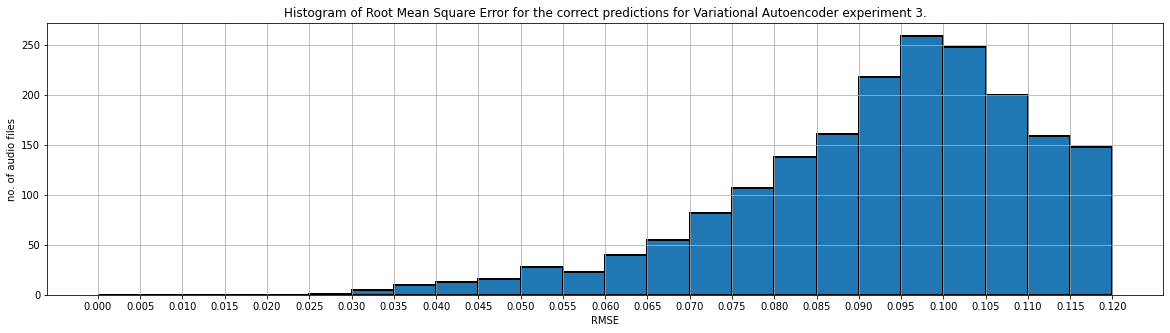

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Variational Autoencoder experiment 3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

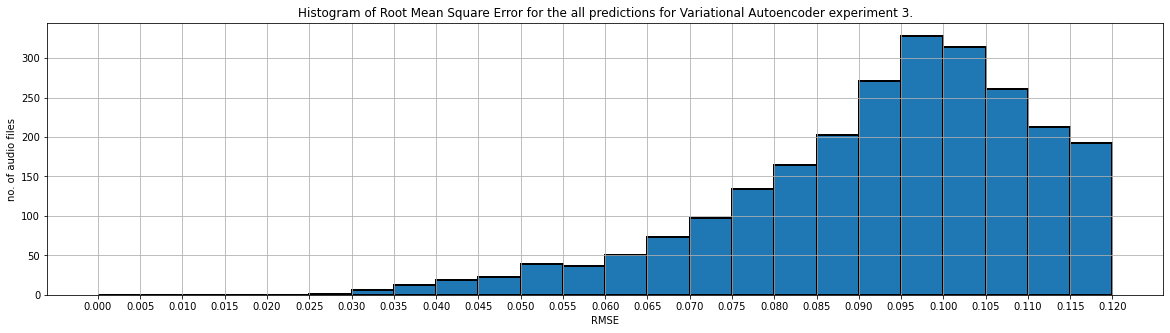

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Variational Autoencoder experiment 3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Variational Autoencoder experiment 3

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.94 0.91 0.8  0.56 0.85 0.81 0.75 0.93 0.72 0.81 0.69 0.55 0.84 0.51
 0.8  0.86 0.67 0.87 0.8  0.75]
Precision:  [0.77 0.91 0.78 0.63 0.86 0.83 0.8  0.91 0.71 0.76 0.75 0.65 0.76 0.59
 0.87 0.87 0.76 0.81 0.71 0.76]
F1-Score:  [0.85 0.91 0.79 0.59 0.85 0.82 0.78 0.92 0.71 0.79 0.72 0.59 0.8  0.55
 0.83 0.87 0.71 0.84 0.75 0.75]
Accuracy: 0.79  , 2703
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        18
           1       0.91      0.91      0.91       236
           2       0.78      0.80      0.79       180
           3       0.63      0.56      0.59       222
           4       0.86      0.85      0.85       212
           5       0.83      0.81      0.82       178
           6       0.80      0.75      0.78       213
           7       0.91      0.93      0.92       173
           8       0.71      0.72      0.71       220
           9       0.76      0.81      0.79       163
          10     

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

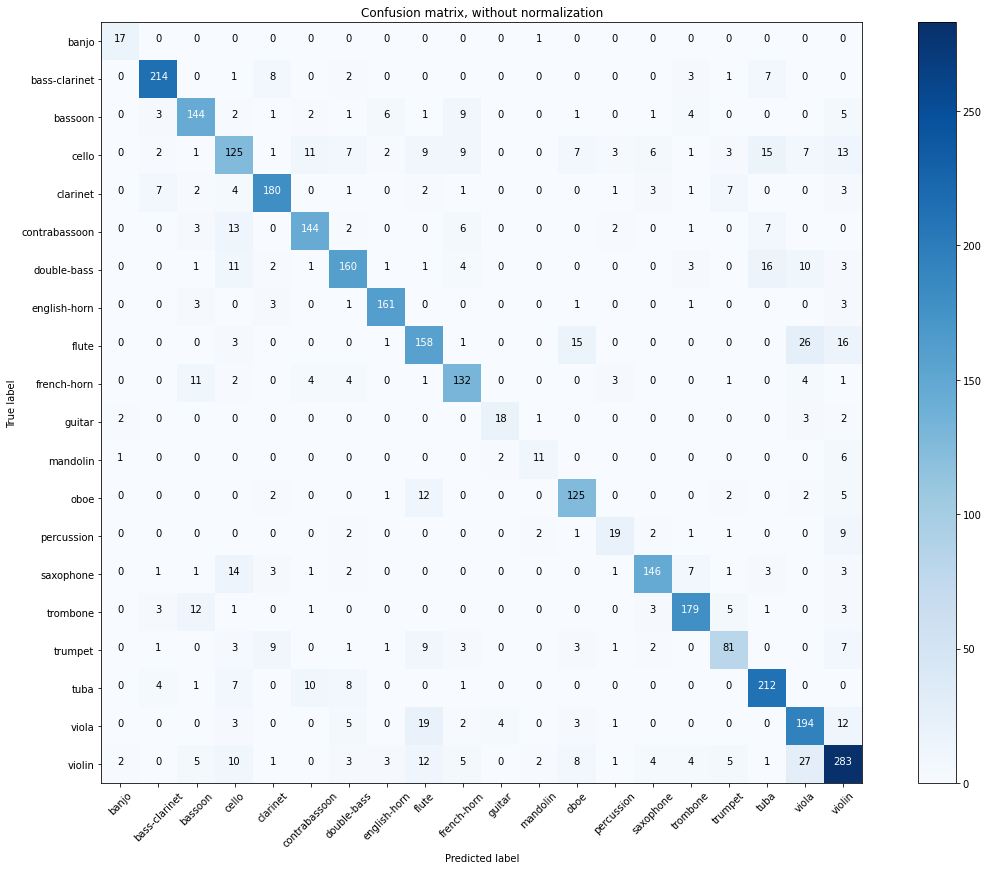

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Experiment Results for Variational Autoencoder experiment 4**

#  load pickle file needed for plotting results for Variational Autoencoder experiment 4

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/VarAutoEncoderExperiment4/histVarAutoEncexp4.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
#print(hist)

In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 739 (out of 3421)
Validation correct 2682 (out of 3421)


In [ ]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
#print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])

for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])


#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

In [ ]:
test_list = test_set['duration'].values.tolist()
#print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
#print(len(correct_pred_value))

In [ ]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))


Duration histograms for wrong and correct predictions for Variational Autoencoder experiment 4

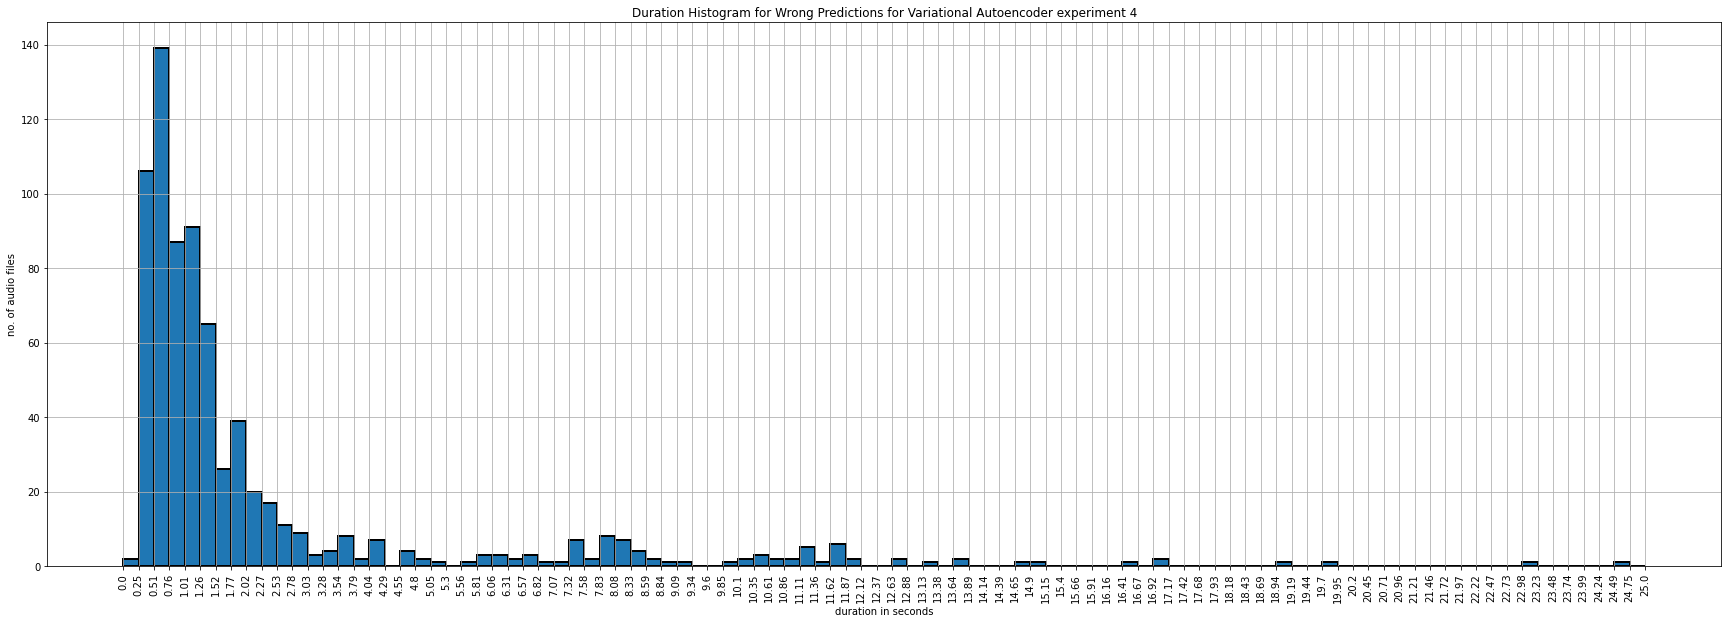

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Variational Autoencoder experiment 4")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

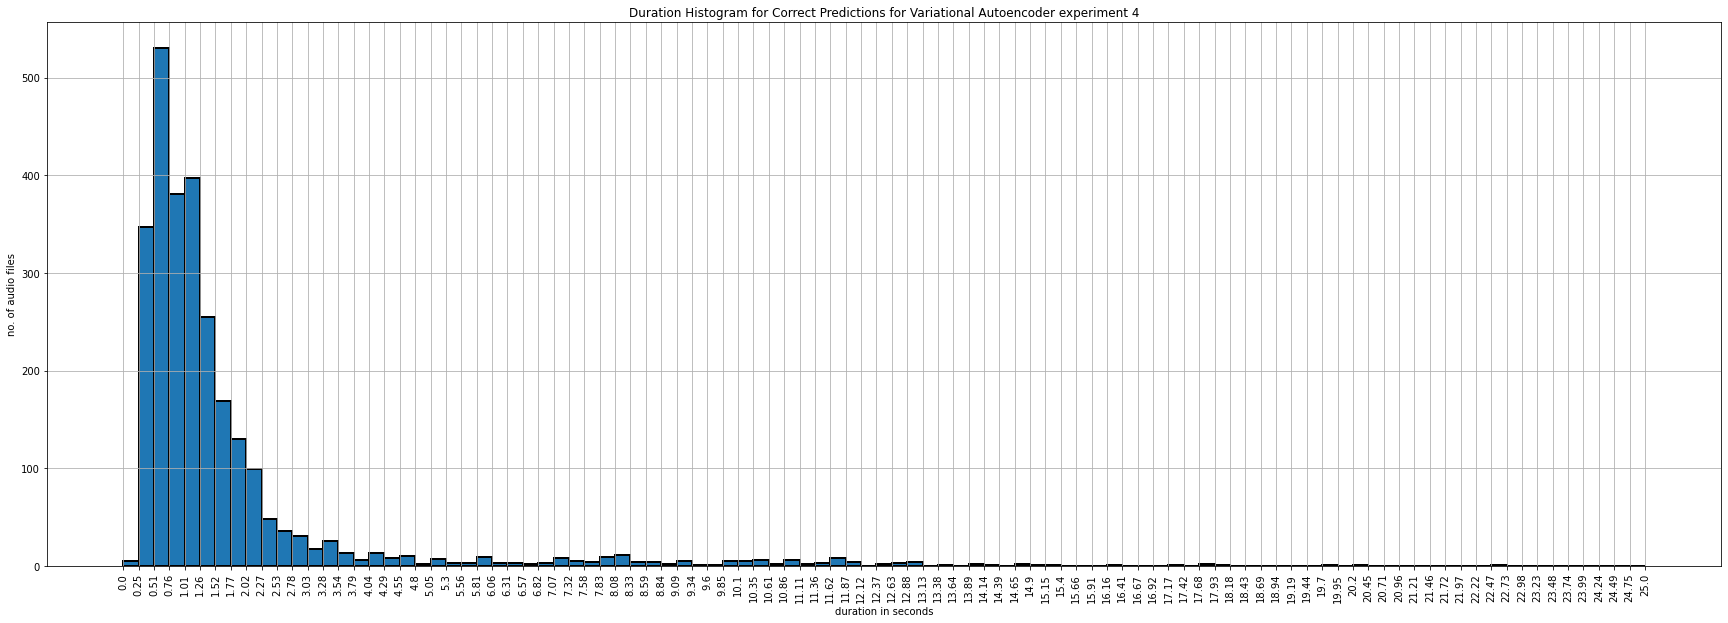

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Variational Autoencoder experiment 4")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for Variational Autoencoder experiment 4

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

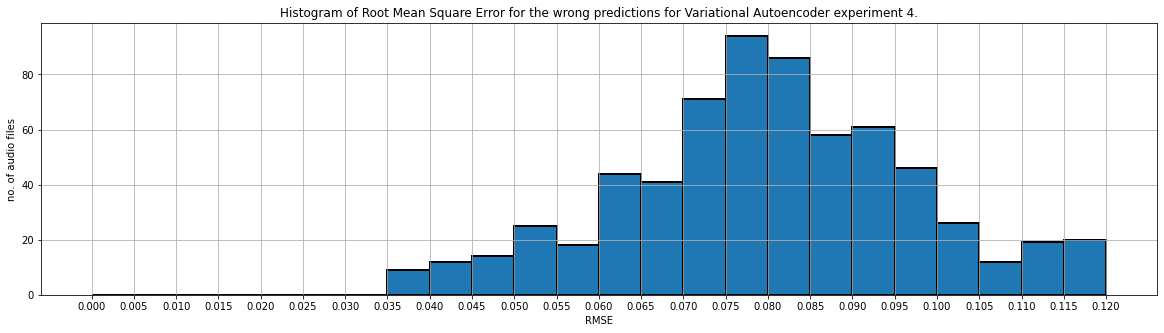

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Variational Autoencoder experiment 4.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

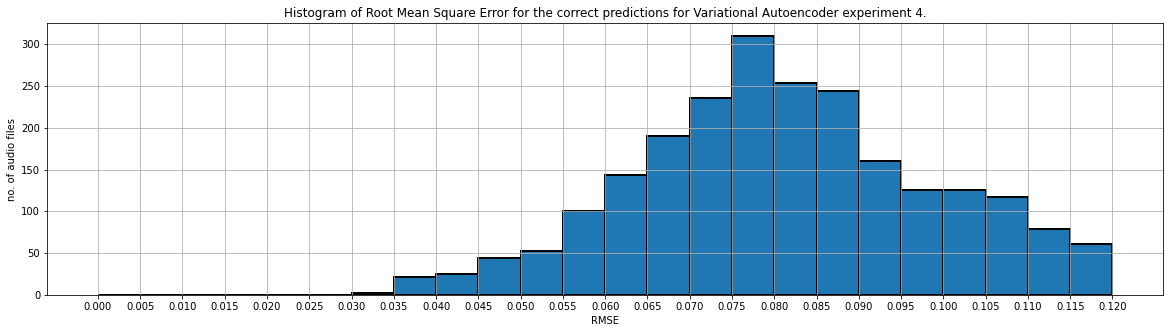

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Variational Autoencoder experiment 4.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

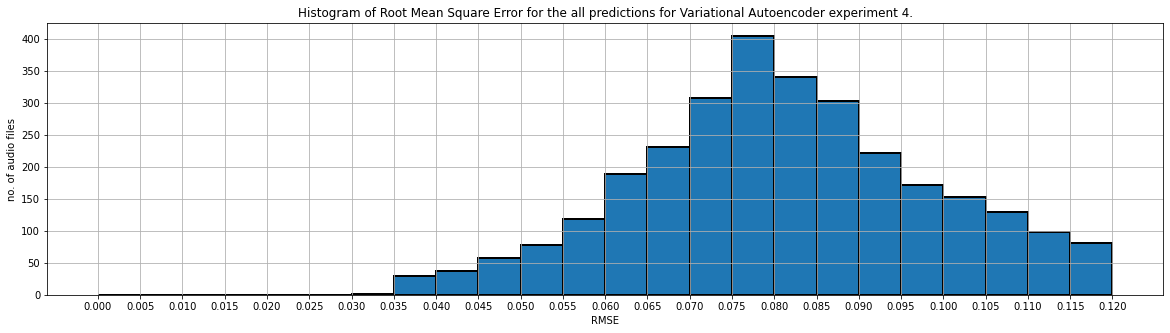

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Variational Autoencoder experiment 4.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Variational Autoencoder experiment 4

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.89 0.9  0.84 0.54 0.87 0.79 0.75 0.91 0.65 0.83 0.77 0.75 0.87 0.59
 0.73 0.84 0.62 0.83 0.81 0.78]
Precision:  [0.89 0.93 0.77 0.64 0.81 0.71 0.82 0.92 0.67 0.81 0.91 0.79 0.79 0.65
 0.84 0.88 0.74 0.79 0.67 0.78]
F1-Score:  [0.89 0.92 0.81 0.58 0.84 0.75 0.79 0.92 0.66 0.82 0.83 0.77 0.83 0.62
 0.78 0.86 0.68 0.81 0.73 0.78]
Accuracy: 0.78  , 2682
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        18
           1       0.93      0.90      0.92       236
           2       0.77      0.84      0.81       180
           3       0.64      0.54      0.58       222
           4       0.81      0.87      0.84       212
           5       0.71      0.79      0.75       178
           6       0.82      0.75      0.79       213
           7       0.92      0.91      0.92       173
           8       0.67      0.65      0.66       220
           9       0.81      0.83      0.82       163
          10     

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

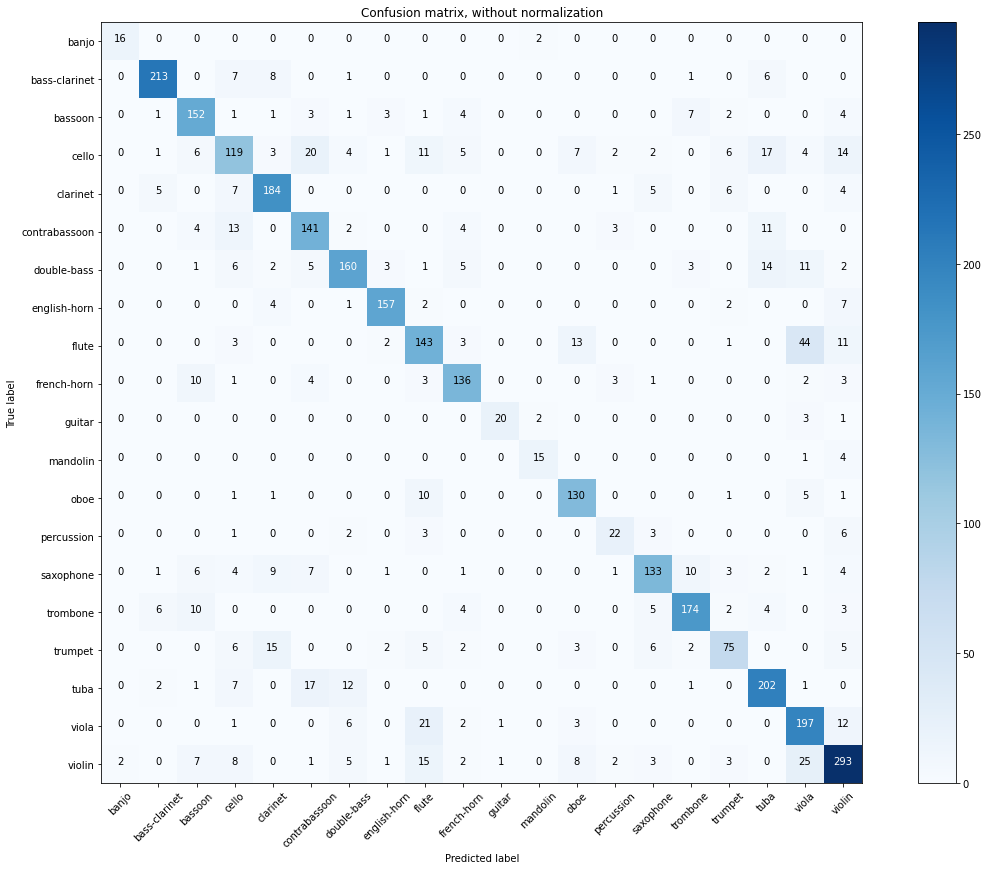

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Experiment Results for Variational Autoencoder experiment 5**

#  load pickle file needed for plotting results for Variational Autoencoder experiment 5

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/VarAutoEncoderExperiment5/histVarAutoEncexp5.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
#print(hist)

In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 806 (out of 3421)
Validation correct 2615 (out of 3421)


In [ ]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
#print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])

for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])


#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

In [ ]:
test_list = test_set['duration'].values.tolist()
#print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
#print(len(correct_pred_value))

In [ ]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))


Duration histograms for wrong and correct predictions for Variational Autoencoder experiment 5

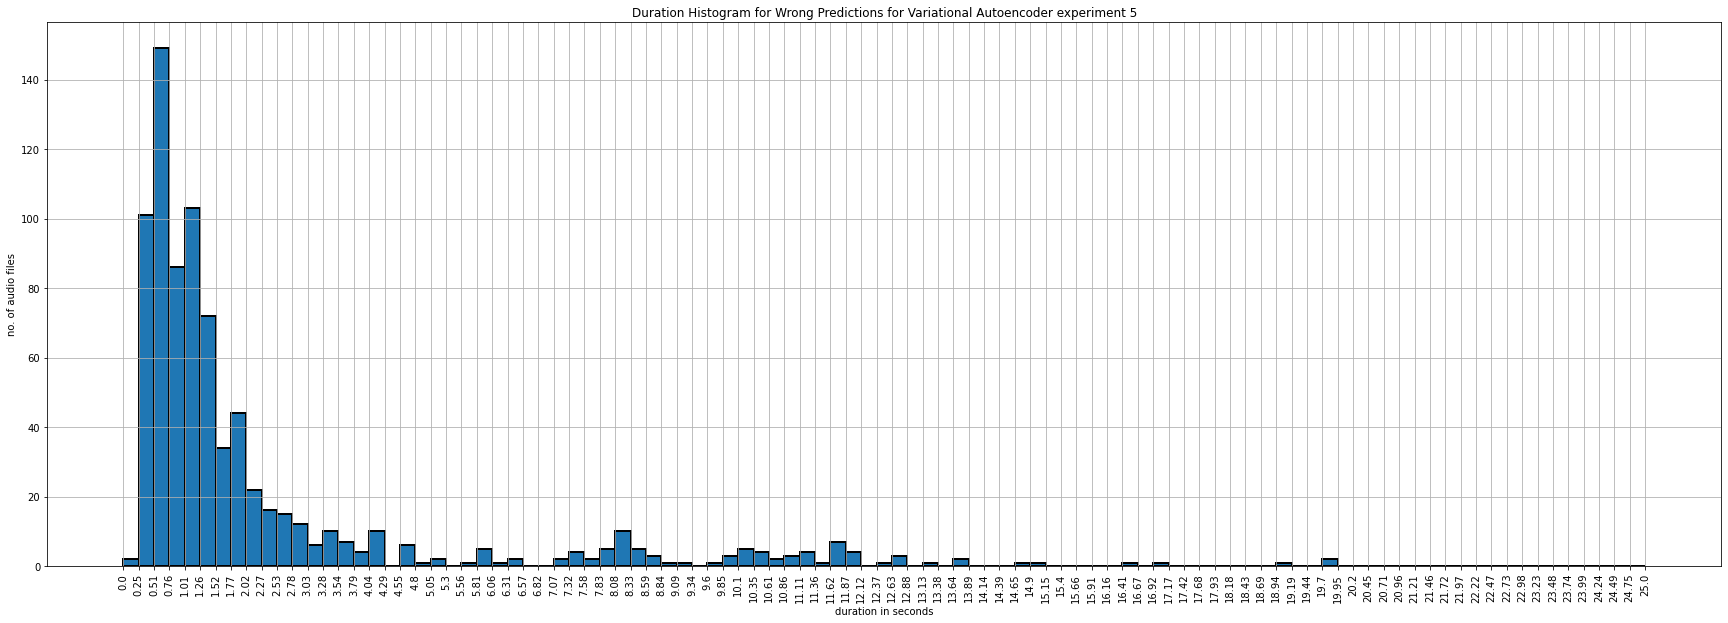

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Variational Autoencoder experiment 5")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

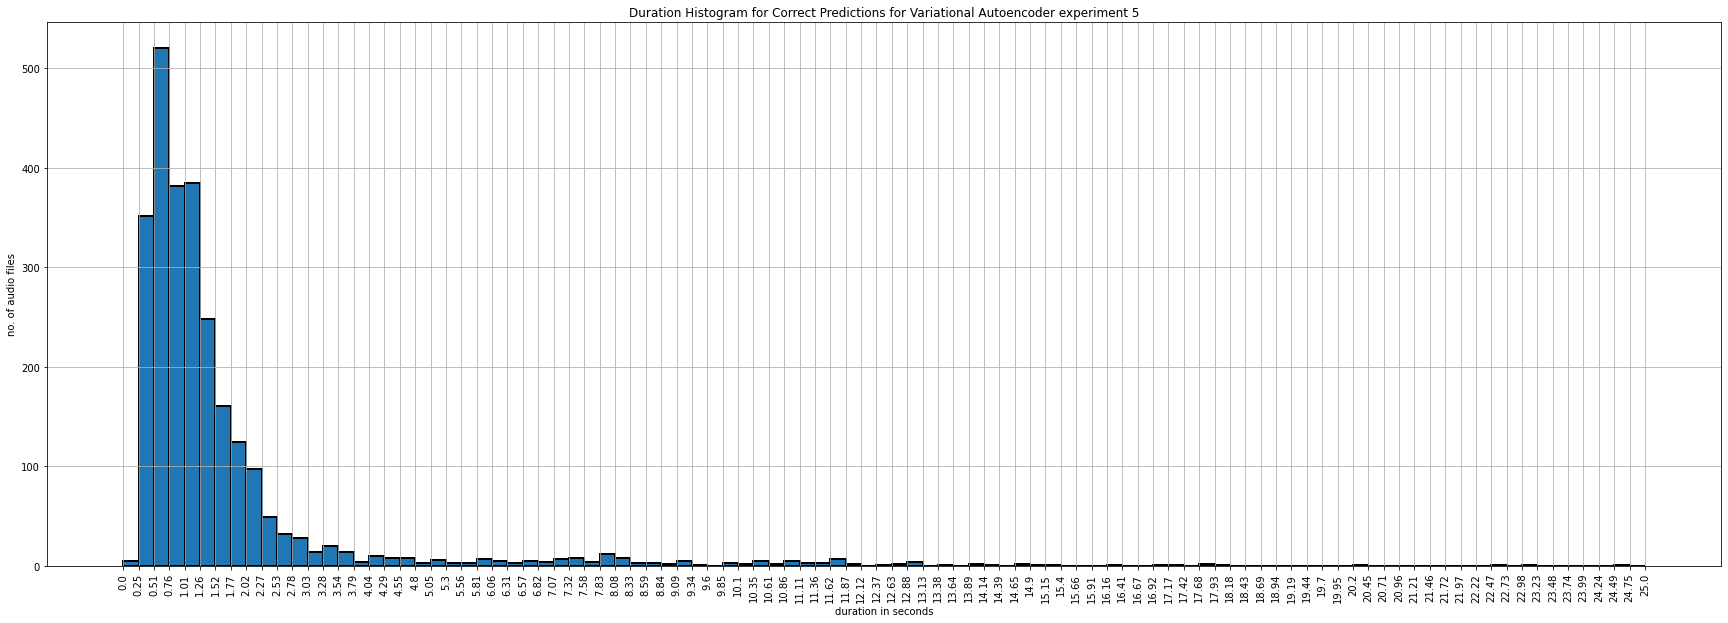

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Variational Autoencoder experiment 5")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for Variational Autoencoder experiment 5

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

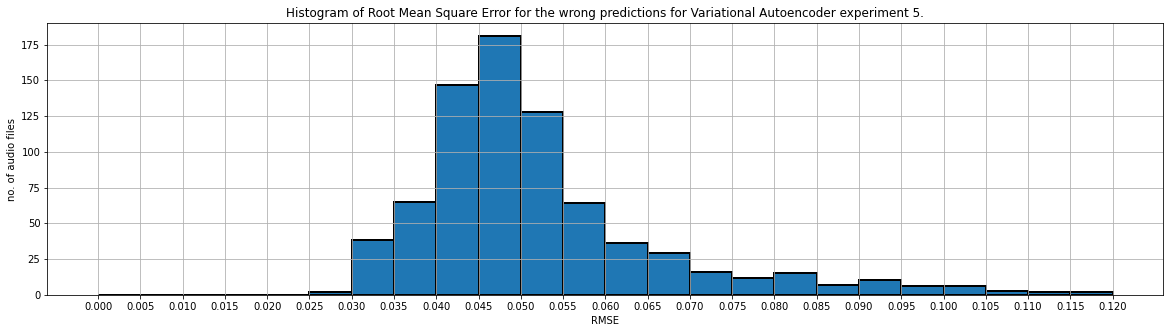

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Variational Autoencoder experiment 5.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

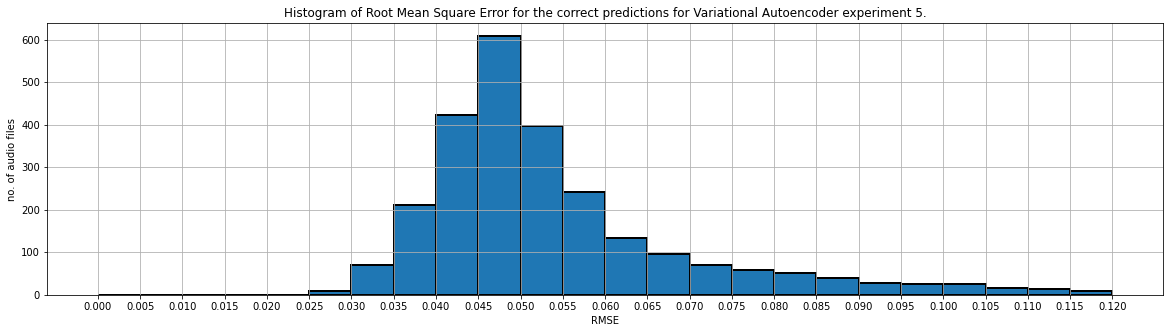

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Variational Autoencoder experiment 5.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

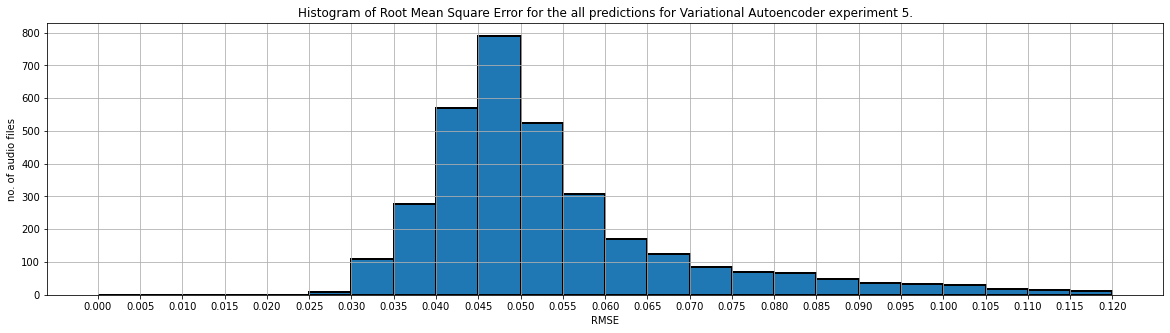

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Variational Autoencoder experiment 5.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Variational Autoencoder experiment 5

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.83333333 0.85169492 0.81666667 0.51801802 0.83962264 0.78651685
 0.69953052 0.90751445 0.66363636 0.72392638 0.84615385 0.55
 0.85234899 0.43243243 0.72677596 0.8125     0.58677686 0.86419753
 0.79423868 0.78989362]
Precision:  [0.9375     0.91780822 0.7        0.60526316 0.77391304 0.76923077
 0.81420765 0.86263736 0.68544601 0.76623377 0.84615385 0.73333333
 0.83552632 0.5        0.80120482 0.88481675 0.71       0.75539568
 0.6942446  0.73514851]
F1-Score:  [0.88235294 0.88351648 0.75384615 0.55825243 0.80542986 0.77777778
 0.75252525 0.88450704 0.6743649  0.7444795  0.84615385 0.62857143
 0.84385382 0.46376812 0.76217765 0.84711779 0.64253394 0.80614203
 0.74088292 0.76153846]
Accuracy: 0.76  , 2615
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.92      0.85      0.88       236
           2       0.70      0.82      0.75       180
           3       0.61      0.52  

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

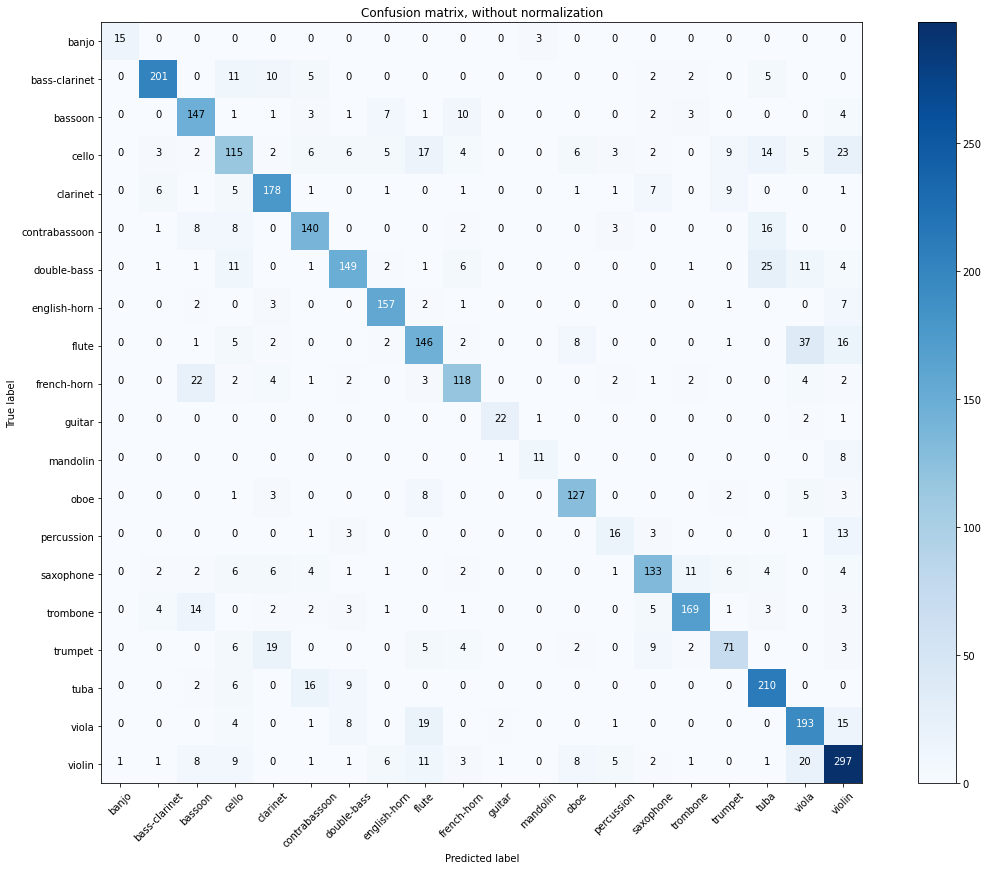

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')